# Compare posts with different reader responses
How readily can we identify posts that tend to receive very different questions from different reader groups?

In [5]:
## load post, question, author data
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_sample_data
sample_type = None
post_question_data = load_sample_data(sample_type=sample_type)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (1,2,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
print(post_question_data.shape)

(288653, 19)


Let's get a filtered data set of paired posts.

In [55]:
 # sample N pair of questions per reader group per post
import pandas as pd
import numpy as np
from tqdm import tqdm
author_vars = ['expert_pct_bin', 'relative_time_bin', 'location_region']
flat_question_data = pd.melt(post_question_data, id_vars=['author', 'parent_id', 'id', 'question_id', 'question', 'created_utc', 'subreddit'],
                             value_vars=author_vars, var_name='group_category',
                             value_name='author_group')
flat_question_data.dropna(subset=['author_group'], inplace=True)
flat_question_data = flat_question_data[flat_question_data.loc[:, 'author_group'] != 'UNK']
## get paired data
paired_group_question_data = []
num_groups_per_category = 2
for category_i, data_i in flat_question_data.groupby('group_category'):
    author_groups_i = data_i.loc[:, 'author_group'].unique()
    for id_j, data_j in tqdm(data_i.groupby('parent_id')):
        np.random.shuffle(data_j.values)
        ## get max(group_count) questions for each group, and oversample
        if (data_j.loc[:, 'author_group'].nunique() == num_groups_per_category):
            data_j_1 = data_j[data_j.loc[:, 'author_group'] == author_groups_i[0]]
            data_j_2 = data_j[data_j.loc[:, 'author_group'] == author_groups_i[1]]
            max_group_count_j = data_j.loc[:, 'author_group'].value_counts().max()
            data_j_1 = data_j_1.loc[np.random.choice(data_j_1.index, max_group_count_j, replace=(data_j_1.shape[0] < max_group_count_j))]
            data_j_2 = data_j_2.loc[np.random.choice(data_j_2.index, max_group_count_j, replace=(data_j_2.shape[0] < max_group_count_j))]
            paired_group_question_data.extend([data_j_1, data_j_2])
paired_group_question_data = pd.concat(paired_group_question_data,axis=0)
print(f'after paired sampling: question data has label distribution = {paired_group_question_data.loc[:, "author_group"].value_counts()}')
print(f'after paired sampling: question data has subreddit distribution = {paired_group_question_data.loc[:, "subreddit"].value_counts()}')

100%|██████████| 127373/127373 [01:26<00:00, 1470.77it/s]


after paired sampling: question data has label distribution = 0.0      100636
1.0      100636
NONUS      4306
US         4306
Name: author_group, dtype: int64
after paired sampling: question data has subreddit distribution = AmItheAsshole      160736
personalfinance     20056
Advice              12546
legaladvice         11080
pcmasterrace         5466
Name: subreddit, dtype: int64


In [61]:
## reorganize data
np.random.seed(123)
paired_sample_size = 10
paired_sample_data = []
pair_data_cols = ['question', 'author', 'author_group', 'id', 'question_id']
for (subreddit_i, group_i), data_i in paired_group_question_data.groupby(['subreddit', 'group_category']):
    sample_ids_i = np.random.choice(data_i.loc[:, 'parent_id'].unique(), paired_sample_size, replace=(data_i.shape[0] < paired_sample_size))
    group_vals = data_i.loc[:, 'author_group'].unique()
    for id_j in sample_ids_i:
        data_j = data_i[data_i.loc[:, 'parent_id']==id_j]
        data_j_1 = data_j[data_j.loc[:, 'author_group']==group_vals[0]].iloc[0, :]
        data_j_2 = data_j[data_j.loc[:, 'author_group']==group_vals[1]].iloc[0, :]
        # fix col names
        data_j_1 = data_j_1.loc[pair_data_cols]
        data_j_2 = data_j_2.loc[pair_data_cols]
        data_j_1.rename({x : f'{x}_1' for x in pair_data_cols}, inplace=True)
        data_j_2.rename({x : f'{x}_2' for x in pair_data_cols}, inplace=True)
        pair_data_j = pd.concat([data_j_1, data_j_2], axis=0)
        pair_data_j = pair_data_j.append(pd.Series({'parent_id' : id_j, 'subreddit' : subreddit_i, 'group_category' : group_i}))
        paired_sample_data.append(pair_data_j)
paired_sample_data = pd.concat(paired_sample_data, axis=1).transpose()
# add post text
paired_sample_data = pd.merge(paired_sample_data, post_question_data.loc[:, ['parent_id', 'post']], on='parent_id', how='left')
paired_sample_data.drop_duplicates(['parent_id', 'group_category'], inplace=True)
display(paired_sample_data.head())

,question_1,author_1,author_group_1,id_1,question_id_1,question_2,author_2,author_group_2,id_2,question_id_2,parent_id,subreddit,group_category,post
0,Do other people use your till?,QuietKat87,0.0,e1rve2u,4897614937304377599,Would you even have that kind of money in the register?,imprl59,1.0,e1s3lge,-6206185301667919699,8vxspg,Advice,expert_pct_bin,"I started working at a dollar general recently and today at the end of my shift i was told i was down 378$, now i know I'm not the smartest but i got to say that's fucking impossible. I don't wanna say someone is stealing from my drawer but over 300, WHAT THE FUCK. What do you guys think is up? I have work tomorrow at 11, Do you think I'm going to get fired?"
2,Major in Business Administration?,ChulitoBurito,0.0,eqi461d,9105910044809847077,Does that sound like the kind of work you’d like to do?,jrkressly,1.0,eqi6ng9,408077323603803002,byiwul,Advice,expert_pct_bin,"Sorry, very long read ahead... **TL;DR at the end**\n\n(FYI i'm in Australia - Sydney... i also don't know if i'm posting in the right place, if not please redirect me to a more appropriate sub to post this in).\n\n&amp;#x200B;\n\nI'm in my fourth year of uni studying something i thought i would be interested in back in high school and during first year (it's health sciences with a major in hearing and speech if anyone was wondering)... i've never had any actual aspirations/ambitions like ""y..."
4,"... ok, then where is the betrayal ?",Lawandchaos4all,0.0,exeej1b,-1605620476787478720,What else is he with holding?,ByebyeBri,1.0,erwxv3v,3140859182481287352,c4jnd6,Advice,expert_pct_bin,"I wasn’t sure where to post this, it’s too much for r/relationships. I just need some advice because I have no one to talk to about this.\n\nI (27f) have been with my fiancé (27m) for three years. Our wedding is in two weeks and we are having 200 guests, 48 of them who are flying in from out of state. \n\nMy fiancé’s sister M was always been stand-off ish with me.\nWe got engaged &amp; announced it to his family &amp; also asked his sisters to be bridesmaids since we want all our siblings to..."
6,Who does he have left to hurt to get to you?,KittyKiitos,0.0,falivrx,7764436972148547697,"Is the car in your name (if so, hiding the keys can be theft)?",TheUncagedRage0,1.0,fak5fgi,8969018846311394041,e9nxoi,Advice,expert_pct_bin,"Three days ago my boyfriend Angelo killed my beautiful husky Luna by leaving her outside in -10 degree (F) weather for 16 hours. I was on a work trip and got home to my kids (11 and 6, Not his) crying saying Luna was outside and Angelo left them home alone. \n\nI of course called the cops but Angelo kept saying it was accidental and he forgot about Luna. Cops didn’t believe any of it and took him in but I can’t press charges. I can legally, but he is really scaring me.\n\nHe isn’t telling me..."
12,"If you end up with a girl that makes a big deal out of your virginity or inexperience, why are you with her?",mamewear,0.0,e45y11m,6653472647813085901,Have you gotten a handy?,The_Shwassassin,1.0,e45zsb6,-381937660623433126,976u83,Advice,expert_pct_bin,"As much as I try to be cool with it, It's been eating me from the inside out, making me feel like there's something wrong with me, like I'm a loser or that I don't belong. A feeling I've unfortunately felt my entire childhood, and apparently has remained into my early adult years.\n\nI'm not particularly ugly, in fact I workout and I've had a few girlfriends and some girls interested in me, but somehow I've yet to lose my virginity. I've had the chance to, twice, but both times I didn't know..."


Next, let's identify highly different questions using sentence representations.

In [69]:
from sentence_transformers import SentenceTransformer
sentence_encoder = SentenceTransformer('paraphrase-distilroberta-base-v1')
question_vars = ['question_1', 'question_2']
for question_var in question_vars:
    question_embed = sentence_encoder.encode(paired_sample_data.loc[:, question_var].values.tolist())
    paired_sample_data = paired_sample_data.assign(**{
        f'{question_var}_embed' : [question_embed[i, :] for i in range(len(question_embed))]
    })

In [70]:
## compute similarity
from sklearn.metrics.pairwise import cosine_similarity
paired_sample_data = paired_sample_data.assign(**{
    'question_sim' : paired_sample_data.apply(lambda x: cosine_similarity(x.loc['question_1_embed'].reshape(1,-1), x.loc['question_2_embed'].reshape(1,-1))[0][0], axis=1)
})

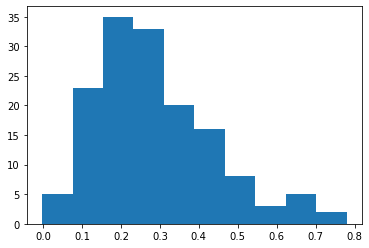

In [71]:
## show similarity distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(paired_sample_data.loc[:, 'question_sim'])
plt.show()

In [44]:
## show questions with similarity
display(paired_sample_data.sort_values('question_sim', inplace=False, ascending=False).head())

,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
1024,Do you have experience in either of these areas?,0.0,Do you have any work experience in either of t...,1.0,b05anb,personalfinance,relative_time_bin,"Hi guys im 30 and have 60,000 in student debt....","[0.10590013, -0.079324655, -0.11441594, 0.4048...","[-0.06240458, 0.054357965, -0.0037658003, 0.07...",0.779525
796,How much was the loan?,0.0,What kind of loan is it?,1.0,a732kd,legaladvice,relative_time_bin,So my mother passed away very recently. My st...,"[0.22187436, 0.022212364, -0.023496933, 0.2266...","[0.17626753, 0.107457064, 0.00895483, 0.098473...",0.756840
800,So when you called the police to report the as...,0.0,Have you made a police report regarding the as...,1.0,d57f12,legaladvice,relative_time_bin,"I started a job (MO) a coworker, who is more s...","[-0.07513836, -0.24335006, -0.025530538, 0.123...","[-0.006427912, -0.30370298, -0.14433903, 0.263...",0.697452
891,Do you wear headphones when playing games with...,NONUS,Are you using headphones?,US,8wsub8,pcmasterrace,location_region,everytime i try to play a game with friends th...,"[0.23348232, 0.36670563, -0.013099973, 0.29672...","[0.31098667, 0.6019713, -0.0992526, 0.11102138...",0.682285
825,Are you using headphones?,0.0,Do you wear headphones when playing games with...,1.0,8wsub8,pcmasterrace,expert_pct_bin,everytime i try to play a game with friends th...,"[0.3109868, 0.6019713, -0.09925248, 0.11102138...","[0.23348232, 0.36670563, -0.013099973, 0.29672...",0.682285


Great! Questions with high similarity do tend to have similar meaning.

What are some examples of posts from different subreddits that have highly different questions from members of different reader groups?

In [51]:
pd.set_option('display.max_colwidth', 500)
for (group_i, subreddit_i), data_i in paired_sample_data.groupby(['group_category', 'subreddit']):
    print(f'**** subreddit={subreddit_i}; group={group_i} ****')
    print('top-K least similar questions')
    data_i.sort_values('question_sim', inplace=True, ascending=True)
    display(data_i.head(5))
    print('top-K most similar questions')
    data_i.sort_values('question_sim', inplace=True, ascending=False)
    display(data_i.head(5))

**** subreddit=Advice; group=expert_pct_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
14,Have you read the Artist’s Way by Julia Cameron?,0.0,What do you usually use?,1.0,cqor9o,Advice,expert_pct_bin,Ive been having some art block ever since the holidays started and ive downloaded multiple apps to help but i cant seem to find motivation to fo anything at all.Anyone have any advise?,"[0.01778617, -0.1455391, 0.05048195, 0.0022236148, -0.17560902, 0.3156606, -0.3203355, 0.0013474544, -0.1344157, -0.014050547, 0.13512902, 0.043762557, 0.01683456, -0.1362584, 0.42189518, 0.13662447, -0.7942923, -0.15689182, 0.20687047, -0.1438757, -0.016713062, -0.15140387, -0.33771074, 0.039446115, -0.27254182, 0.11881481, -0.25935206, 0.014816523, -0.063274525, 0.102619044, -0.04798431, -0.012124314, -0.2128807, 0.042827383, -0.3594974, 0.2873308, -0.00084789196, 0.0073269447, 0.18081649,...","[0.21613614, 0.1984612, -0.251404, 0.27464354, 0.06621878, -0.26097694, 0.065881886, -0.31743848, -0.00616242, 0.12758347, -0.018597603, -0.4349069, 0.5262135, -0.16121952, -0.1809693, 0.039581805, -0.5624604, -0.008823758, 0.06315836, -0.37464902, -0.07629229, -0.09815755, -0.07512421, 0.076104835, 0.08445452, -0.22552605, -0.010692194, 0.26886147, 0.26834017, -0.14009613, -0.050686862, 0.02882412, -0.23955776, 0.06358763, -0.0061578527, -0.43694183, -0.2609672, -0.21597032, -0.01310125, 0....",0.089994
12,"If you end up with a girl that makes a big deal out of your virginity or inexperience, why are you with her?",0.0,Have you gotten a handy?,1.0,976u83,Advice,expert_pct_bin,"As much as I try to be cool with it, It's been eating me from the inside out, making me feel like there's something wrong with me, like I'm a loser or that I don't belong. A feeling I've unfortunately felt my entire childhood, and apparently has remained into my early adult years.\n\nI'm not particularly ugly, in fact I workout and I've had a few girlfriends and some girls interested in me, but somehow I've yet to lose my virginity. I've had the chance to, twice, but both times I didn't know...","[0.2253975, 0.41145912, -0.0388206, 0.24149418, 0.19594173, 0.06537137, 0.2147945, 0.12685378, 0.18431552, 0.03374597, -0.13665971, 0.3190514, -0.063565314, 0.19250743, -0.12561475, 0.67894065, -0.5035617, 0.4398666, 0.13484071, 0.1022525, -0.06265421, -0.08683666, -0.14323536, 0.14147152, -0.059349243, -0.080189385, 0.16299048, -0.2184437, 0.34446558, 0.14376344, 0.33695486, 0.2401823, 0.06249685, 0.15105203, -0.06775333, 0.15128241, -0.05424083, 0.09509554, -0.23088706, -0.099107996, 0.326...","[0.22106142, -0.38524073, -0.031409636, 0.099106915, -0.5301462, 0.22897911, 0.039562877, 0.097455874, -0.19099577, -0.21414825, -0.23818463, -0.48895788, 0.22763208, 0.37153715, -0.23473313, 0.10387865, -0.19875164, 0.011865541, -0.26176426, -0.73198044, -0.20937103, 0.05105511, 0.09894749, 0.1571732, 0.045063317, -0.4243699, 0.027191602, -0.1650879, -0.00042969733, -0.057059914, -0.30013478, 0.60076284, -0.22024517, -0.24740726, -0.014637537, -0.30178517, -0.12310567, -0.07176443, -0.00264...",0.093740
2,Major in Business Administration?,0.0,Does that sound like the kind of work you’d like to do?,1.0,byiwul,Advice,expert_pct_bin,"Sorry, very long read ahead... **TL;DR at the end**\n\n(FYI i'm in Australia - Sydney... i also don't know if i'm posting in the right place, if not please redirect me to a more appropriate sub to post this in).\n\n&amp;#x200B;\n\nI'm in my fourth year of uni studying something i thought i would be interested in back in high school and during first year (it's health sciences with a major in hearing and speech if anyone was wondering)... i've never had any actual aspirations/ambitions like ""y...","[0.12460729, 0.3399945, 0.18949723, 0.27347678, 0.10530419, -0.28187373, -0.02273293, 0.20604244, -0.0058165616, -0.24680892, 0.15342471, 0.3565317, 0.035801582, -0.22375396, -0.37985405, 0.4578156, -0.24917567, 0.12175035, 

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
19,How old is the cat?,0.0,"So, your friend’s cat is staying at your place?",1.0,8o8iwh,Advice,expert_pct_bin,"I’m cat sitting for a friend for a month. Starting around 4AM this cat will get up and start wailing loudly with every breath. I’ve known cats to run around and maybe chirp once or twice around this time, but never put on an opera. I live in a studio apartment with the landlord next door who’s already complained a few times about the noise. I haven’t slept well in over a week now. I’ve tried ignoring and punishing (pick up and blow in the face) without any success. I make sure food and litte...","[0.160936, 0.1304992, 0.2851125, 0.1667904, 0.13860685, 0.23865372, -0.1678858, 0.12810828, 0.29787347, -0.1772458, -0.33084318, -0.17603905, 0.12431844, -0.45096564, 0.14169233, 0.23145905, -0.18866573, 0.37237433, -0.022008594, -0.12033885, -0.0039979666, -0.14740907, 0.38261226, -0.060433492, -0.19296159, 0.17166987, -0.2621846, -0.079414755, -0.26439768, 0.016450927, 0.11671355, -0.01723028, -0.13956988, 0.025996005, 0.12988754, 0.043141827, -0.22954598, -0.01992175, 0.12577206, -0.15367...","[0.05976024, 0.041118935, 0.19509718, 0.38713163, 0.055253807, 0.18442069, 0.017175894, 0.059696708, 0.21951707, 0.05524624, -0.20536326, -0.618763, 0.28164732, -0.43976775, -0.10428819, 0.10949374, -0.38666275, 0.27488264, 0.09169546, -0.31302527, -0.16985238, 0.020581286, 0.16112235, 0.022081211, -0.5177518, -0.028188393, -0.23088866, 0.080749825, -0.16479558, -0.14396676, 0.014549535, -0.08076238, -0.0734452, 0.16320693, 0.100890145, -0.002576135, -0.20621878, 0.089970544, -0.02625277, -0...",0.471470
16,Do you have a Planned Parenthood in your area?,0.0,Why is this your only chance to have a baby?,1.0,dg5426,Advice,expert_pct_bin,"Alright so I’m gonna keep this short and simple it explains some sort of thing in the title, pretty much I’m pregnant my boyfriend doesn’t live in my town and I wanna live with him or at least be with him. My town is pretty shitty and a lot goes on here and it’s not a place a baby should grow up in or even be around. I don’t want to resort to any sort of abortion because this is my only chance to have a baby, I don’t know for sure if my family would let me leave just like that or if they’d m...","[0.16203769, -0.007081181, 0.108441204, 0.08489368, -0.46643928, 0.48876834, 0.009010643, 0.17232443, -0.12001521, 0.086639844, 0.06614723, 0.15292913, -0.07425653, -0.28029504, 0.21171804, 0.54940873, -0.08920253, -0.46303332, 0.0076952926, 0.24516207, -0.022719383, 0.17310543, -0.027355999, 0.11643497, -0.1887515, 0.23379065, 0.0002530838, -0.14376192, 0.6499381, -0.3261546, 0.16897316, 0.021395648, 0.049802553, -0.124442376, 0.31967893, -0.07150335, 0.033192012, -0.01436231, 0.13681556, -...","[0.14511159, 0.20903745, 0.008189536, 0.1813319, -0.36839202, -0.20496365, 0.09900458, -0.040131763, 0.052592732, -0.123314984, -0.09237475, 0.05412225, -0.0075205015, -0.11736296, -0.11490026, -0.13246039, -0.54666317, -0.26266262, 0.168098, 0.070819154, -0.0039276527, 0.23506102, 0.21878353, 0.2110932, -0.6487592, 0.18537305, -0.14500666, 0.01122813, 0.37745032, 0.2850807, -0.015259798, -0.16594847, -0.13848203, 0.047287915, 0.039887488, -0.057317737, -0.113491245, -0.083956614, 0.09894996...",0.315152
0,Do other people use your till?,0.0,Would you even have that kind of money in the register?,1.0,8vxspg,Advice,expert_pct_bin,"I started working at a dollar general recently and today at the end of my shift i was told i was down 378$, now i know I'm not the smartest but i got to say that's fucking impossible. I don't wanna say someone is stealing from my drawer but over 300, WHAT THE FUCK. What do you guys think is up? I have work tomorrow at 11, Do you think I'm going to get fired?","[0.08584944, -0.22381428, 0.093589276, 0.16559131, -0.56624424, -0.022672674, 0.07786266, 0.127968

**** subreddit=AmItheAsshole; group=expert_pct_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
192,Is America suddenly a muslim country?,0.0,"And you couldn't wait, what, two minutes?",1.0,d2cm6l,AmItheAsshole,expert_pct_bin,\n\nLast week I was on my way home from work when I received a call from my wife. She told me to stop at the gas station to pick up some beer because we were having dinner at her parents house later that night.\n\nWe have a 10 month old and we were planning on both arriving at home around the same time. She had the baby and the plan was to grab the beer park at home and jump in her car to depart to her parents house.\n\nI arrived at the gas station which is always at least moderately busy. ...,"[-0.01789751, 0.12547317, 0.18479761, 0.24094757, 0.33278877, -0.0668554, 0.092628986, -0.1001389, -0.36259454, -0.05414943, -0.0034493178, -0.22592095, -0.10595961, -0.32312173, 0.06808193, -0.02293619, -0.13186793, -0.27438527, -0.11639293, -0.079026565, 0.052606605, -0.21063308, -0.18167627, 0.02785306, 0.06786282, 0.19757922, -0.12855539, -0.33981556, -0.59165823, 0.22831169, 0.27628213, 0.15764457, -0.070967734, -0.1741083, 0.2780672, 0.18618801, 0.008468117, -0.069428824, 0.5381101, -0...","[0.049224816, 0.064716265, 0.16938843, 0.078541584, -0.056422092, -0.099769406, 0.13043185, 0.30410045, 0.38831344, -0.296116, 0.26309007, -0.070699506, 0.071291074, 0.047354676, 0.05427255, 0.5973899, 0.08440122, 0.15978265, 0.26762867, 0.038299702, 0.06411822, -0.14042968, -0.18803798, 0.15217577, -0.16323799, -0.24252695, 0.020900605, -0.19250129, 0.34990725, 0.24103428, 0.17203093, 0.008965022, -0.06578141, -0.28848353, 0.006178411, 0.15427415, -0.30571753, -0.17983072, -0.3398469, -0.05...",0.029063
184,"Or are we talking full hoarder, rooms full of newspapers and actual garbage?",0.0,"INFO: Is you mom struggling with depression, possibly?",1.0,edorek,AmItheAsshole,expert_pct_bin,"Ok before anyone bites my head off, here’s the situation: \nSo I moved out last September to study at uni. Before then I lived in my mothers house most of the week I lived at my dad’s at the weekend. Now I spend a week at each. My dad’s is always clean and tidy then and now. My mother’s was reasonably tidy too but now I’ve come back for winter it’s gotten uncomfortably messy. \n\nHer room, the bathrooms, the dining room and my room are all still really tidy and clean but every other room is...","[0.17622413, -0.20965494, -0.062510505, 0.057051644, -0.0040468774, 0.041589133, -0.062213354, -0.05302767, 0.14007717, -0.10835877, 0.26839703, 0.058585685, -0.038136348, -0.19341789, 0.2300752, -0.46071953, -0.23098098, -0.17366813, 0.32580635, 0.025475979, 0.25367266, 0.09317337, -0.060888216, 0.16302076, -0.075150326, 0.03713703, -0.21292776, -0.013628433, -0.19637224, 0.27201468, 0.18142004, -0.073088974, 0.1905036, -0.055929158, -0.38648805, -0.055099607, 0.316105, 0.0298792, 0.3175156...","[-0.06539741, 0.015872167, 0.19098385, -0.20313025, 0.17968513, -0.57717294, 0.05509181, 0.095255375, 0.01172984, 0.27740765, 0.13884284, 0.08593034, -0.26104814, -0.07723905, -0.21338171, 0.04151845, 0.13387667, -0.06804932, 0.22688238, -0.10804125, -0.12656692, 0.18581446, -0.11394682, 0.016342528, -0.24371152, 0.4097733, -0.024429945, 0.07361711, 0.22001606, 0.27204603, 0.20043965, 0.03296376, -0.22059287, -0.25148973, -0.097920306, -0.08080419, -0.22398224, 0.11771265, -0.09536683, -0.03...",0.081651
200,But is it worth seeing your daughter miserable because you're being a little too shallow to let them spend the night with each other?,0.0,Do you honestly think they would be doing anything different?,1.0,cjqfuw,AmItheAsshole,expert_pct_bin,"Throwaway account. I’m also new to this thread and am seeking some perspective, I do apologise if many similar situations have been brought up before. \n\nMy daughter and her boyfriend are both 20, and have been together for over 1.5 years. BF is over at our house quite ofte

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
198,"Some time after the meal, they announce that you need to pay?",0.0,Why do you assume that your expected to pay for your friend?,1.0,8xxm43,AmItheAsshole,expert_pct_bin,"My friend, who was over for the weekend, and I were at another friend's house for some D&amp;D game night, where overall we had fun and played a one-shot game. The friend had cooked a Medieval-themed meal for all of us, went to a large extent. \n\nThe dinner came out, it was steak, diced bacon, fennel, baked potatoes. \n\nI'd told them a while ago that I was vegetarian. \n\nThey say that they'd forgotten that part, mini-roast for being veggie. I mention that I have food at home i could eat...","[-0.0672258, -0.30503687, 0.016560528, -0.25127268, 0.40476942, -0.16811511, -0.044148717, 0.15193477, 0.056153584, -0.0629038, 0.42728084, -0.28399545, 0.20197892, -0.48398215, 0.37273616, -0.23556888, 0.53399605, 0.15187733, 0.1322883, 0.2569823, -0.13787791, -0.33290777, -0.0091996025, 0.026597098, -0.4794294, -0.027851284, 0.1976752, -0.16596942, 0.1258784, -0.05640562, -0.19412309, -0.1840284, -0.056560352, -0.16978121, -0.025757745, 0.16005981, -0.41576806, 0.0075289384, -0.46453997, -...","[0.16726483, -0.21795072, 0.06623459, 0.10963044, 0.06931577, -0.32563046, -0.0021571794, 0.034073308, -0.03515441, 0.023776086, 0.38836995, 0.10800371, 0.0011009931, -0.29919684, -0.16009529, 0.16213362, -0.15981671, 0.09582836, 0.2420276, -0.17947513, -0.08736623, 0.048844393, -0.12185199, -0.04513481, -0.4357072, -0.22091636, 0.20293607, -0.22823204, -0.178009, 0.06827326, 0.049239744, 0.2564668, -0.20624004, 0.06966545, -0.09489751, 0.05713017, -0.08492362, 0.14896682, -0.19699885, -0.04...",0.477463
159,YTA - how about getting to the bottom of why he's failing instead of punishing the rest of the family?,0.0,As others have said why are you punishing him instead of trying to figure out what's going on?,1.0,c6dvnx,AmItheAsshole,expert_pct_bin,"Throwaway\n\n&amp;#x200B;\n\nMy family had a vacation planned to Orlando from Maine after my kids' school ended. My younger son, 11, failed his some of his end-of-the-year tests. He was the main reason to go on this vacation, as my 16 year old son didn't really want to go. We agreed that he would make sure to do well in school in order to go.\n\n&amp;#x200B;\n\nAfter receiving his report card, I cancelled the plans. I also got an email from his teacher saying he fell asleep in class on one o...","[-0.028743934, 0.22399414, 0.14719482, 0.57462484, 0.48304248, -0.3947811, 0.2146761, 0.021616247, 0.05190737, -0.07233132, 0.33238086, 0.63498473, -0.21758018, -0.0024232112, 0.00793828, -0.024078965, -0.1556113, -0.52806973, -0.11229698, -0.379838, -0.113215916, -0.21277906, -0.15720348, 0.46255574, -0.6282577, -0.061052095, 0.16117987, -0.10404487, -0.010924802, 0.26767898, -0.1759025, 0.0580684, -0.07210664, -0.19607626, -0.1909399, 0.31287688, 0.27338368, 0.04217392, -0.40772465, -0.186...","[-0.15968142, 0.050997213, 0.071451515, 0.44843456, 0.0662271, -0.22934684, 0.267486, -0.24947277, 0.12244217, -5.3077936e-05, 0.24639912, 0.24327447, -0.032768395, -0.23967601, 0.04011642, -0.10011652, 0.029083632, 0.16856658, -0.14794755, -0.06309568, 0.0752732, -0.34045374, -0.67242545, 0.16417553, -0.8614741, -0.06987925, -0.019059451, -0.23344153, 0.08606612, 0.17356367, -0.21067303, 0.07017309, -0.057926726, -0.12109244, 0.05413443, 0.37181616, 0.031296875, 0.02234217, -0.1989612, -0.2...",0.476777
209,NTA- How old is your brother and is it possible for him to stay with you?,0.0,Or can your dad get sole custody?,1.0,bkkewz,AmItheAsshole,expert_pct_bin,"So, a bit of context here. My parents divorced ten years ago and have had joint custody of me and my younger brother. My father was and, in my opinion, still is the better parent, so it was hard to not have him in the same house as us at all times. \nMy mo

**** subreddit=legaladvice; group=expert_pct_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
742,That she had become a topic of conversation?,0.0,Since this relationship is out in the open and nobody is hiding anything what damage do you think could be done here?,1.0,98rwsm,legaladvice,expert_pct_bin,"California, USA. Not concerning myself, but my mother. Throwaway account. **tl;dr version: My mother's old hard-line traditionalist church is threatening to brand her as a non-Christian in front of the congregation without her being there in front of a majority of her friends and local family, need to find a way for that to not happen.**\n\nA bit of background. My mother and father split but never formally divorced several years ago due to the both of them being relatively busy. My mom has s...","[0.32174996, -0.16002016, 0.003141357, 0.18572935, 0.24584326, -0.0010171045, -0.1535088, -0.20096034, -0.3809246, 0.38965407, -0.42303526, 0.070838615, -0.21490704, -0.07777791, 0.22033529, 0.19694012, 0.009388572, 0.20675501, -0.17458656, 0.13896133, 0.13649972, -0.035781804, -0.082457654, -0.5144932, 0.08961412, -0.24764758, -0.27851227, 0.06696306, 0.20402765, 0.25430557, 0.40085423, 0.5696811, -0.08880184, -0.010813514, -0.17912346, 0.032559298, 0.19465405, 0.17124854, 0.27029955, -0.20...","[-0.1478523, -0.078082755, -0.10035133, -0.1680383, 0.08757574, 0.08157059, 0.024853278, -0.32107362, -0.0033365178, 0.09930842, -0.600229, 0.07626194, 0.0765167, -0.22938374, -0.19255449, 0.11633695, -0.23421435, -0.05957521, 0.13934821, 0.43853474, -0.08377991, -0.054887213, 0.39794892, 0.45460168, -0.32389352, -0.1386299, 0.055111036, 0.01720024, -0.047572985, 0.071180895, 0.32389167, 0.21091306, -0.0055094813, -0.127625, -0.21296047, 0.1263311, 0.011411972, 0.00034449578, 0.32667786, -0....",0.101675
740,Did you know about the encroachment before you closed on the house?,0.0,How long has this gone on?,1.0,c6jc02,legaladvice,expert_pct_bin,"I recently bought a house in Minnesota. Having a third stall on the side of my garage was a priority and continues to be one. I spoke with my neighbors one day who told me they gave the previous homeowners verbal permission to have the third stall put in on their property, as city code required a certain width for paved spots on the side of garages. I would estimate it goes 6 inches into their property. \n\nMy concern is while me current neighbors are great, if they move and the new buyers d...","[-0.040818993, -0.4062494, 0.14376481, -0.09143388, -0.71118, 0.27607432, -0.2076248, -0.2234113, -0.25979465, -0.059066426, 0.31220582, -0.36072797, 0.21546313, -0.45208627, 0.11355923, -0.093378186, 0.14911465, -0.23326507, 0.21322067, 0.056671172, -0.021347325, -0.37882826, -0.026751209, 0.049933806, -0.42243558, 0.12347656, -0.12047291, 0.09841971, -0.49932435, 0.41366625, -0.029853806, 0.082240984, 0.09618389, 0.14885816, -0.13321342, -0.17198174, -0.062895, -0.26219982, 0.007706955, -0...","[0.21189772, -0.019909237, 0.14817435, 0.19171163, -0.11869531, -0.050551657, 0.055810776, 0.17551088, -0.32206511, -0.39053154, -0.018709341, -0.34868732, 0.13147898, -0.25680688, 0.081644736, -0.4063505, 0.103537515, 0.13910535, 0.095260166, 0.23312987, -0.24005753, 0.106127396, 0.17239253, 0.15244497, -0.6012804, 0.045148052, -0.014439291, -0.3991841, -0.0624518, -0.0027379212, 0.21001925, 0.16786467, 0.34317228, -0.1186355, 0.17964847, 0.15279973, -0.38406435, -0.0038709408, 0.09989984, ...",0.223159
753,Don't they still have a union?,0.0,So have you filed for unemployment and looked for a new job?,1.0,8rjkrd,legaladvice,expert_pct_bin,"Hi, guys. Ltl, ftp, throwaway account, the usual.\n\nSo until about three weeks ago, I worked for a popular theme park as an attraction attendant. I wasn't a perfect employee (who is?), but my performance reviews were always glowing, and the management team knew me as someone to rely on when things were getting crazy. I do admit that I scr

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
758,"Did the owner ever sign the settlement agreement negotiated by your attorney and if so, what did it say?",0.0,"Was there anything in writing for the agreement where you would move out and keep the back rent, and they would keep the security deposit?",1.0,cvxk6d,legaladvice,expert_pct_bin,"This will be a long one-\nThis is all taking place in Maryland (United States)\n\nIn August 2018, my SO, a friend of ours and myself had all signed onto a 12 month lease for a rental property (a condo). About a month after we had moved in, we received notice that our property was going into foreclosure and would soon be on the market for auction. We were reassured that our lease would still hold true and since we were paying rent through a rental management company, nothing would change and ...","[-0.039618813, 0.10519528, -2.2805256e-05, 0.08927762, 0.022207333, -0.07824826, 0.056399416, -0.22703421, -0.10821162, -0.014043145, -0.121576436, -0.18972683, 0.07924772, -0.27727675, -0.12097904, 0.28659874, 0.41429597, 0.07092959, -0.13407864, 0.102388404, 0.3162388, -0.35901073, 0.111478835, 0.14449115, 0.12901723, 0.12428974, -0.16980429, -0.06903933, -0.26037446, 0.1687376, 0.12570891, 0.32210514, -0.12367037, -0.11491437, 0.056680005, -0.2982375, -0.04221015, -0.24091592, 0.009900352...","[0.05774847, -0.06154818, -0.1858363, 0.43342644, -0.076133974, 0.2264977, 0.012747156, 0.077426784, 0.25168455, -0.073707104, 0.07338797, -0.2769979, -0.13161522, -0.008040163, -0.13119614, 0.17123179, 0.3670601, 0.55449176, 0.021806967, -0.111221656, 0.08424932, -0.19997114, -0.1385853, 0.23301429, -0.21774393, -0.14957601, -0.08990661, -0.13070206, -0.3720008, -0.09607177, 0.14335856, 0.16208208, -0.07197835, 0.06551721, -0.07721211, -0.014143019, -0.25851145, -0.016694127, -0.3612676, 0....",0.543101
749,What do your CCRs say about having vehicles/trailers/boats/etc in your driveway?,0.0,What does your CC&amp;Rs say?,1.0,azp9mg,legaladvice,expert_pct_bin,Please let me know if I should post this elsewhere. My HOA has flagged a “violation” on my property because I have a truck and trailer parked in my driveway. Both are completely on my property and are not blocking the sidewalk or any public or private access. We have a meeting to discuss with the HOA board and plead our case. However other homeowners have complained that fighting is a waste of time and the board will ultimately stick to their guns no matter what. That being said we are e...,"[0.06926602, 0.19854274, -0.1565324, 0.11318143, 0.0649056, 0.3148956, -0.13654587, -0.49524954, -0.046688516, 0.013951778, 0.08545465, 0.3369877, 0.18490839, -0.52646935, 0.07053136, -0.07923208, -0.012225168, 0.032882653, 0.097924665, -0.69725496, 0.04240501, -0.2231327, -0.12158386, -0.085131556, -0.777816, -0.0797893, 0.009373437, 0.23492305, -0.07131149, 0.16674301, 0.052555125, 0.014304962, -0.03943121, 0.10741703, -0.02281867, -0.09978432, 0.053248256, -0.2473645, -0.15721004, 0.11548...","[0.028191129, -0.0041603693, -0.021853754, -0.30888897, 0.31275594, 0.34586692, -0.1955359, -0.10960922, -0.034967206, 0.107111156, 0.41755643, 0.19425867, -0.20568116, -0.23809262, 0.35497823, -0.044115692, 0.31842616, -0.06830297, 0.2851547, -0.21306586, -0.10047605, -0.39625087, 0.35692433, 0.3730816, -0.20733161, -0.025145357, -0.22893745, 0.21572922, -0.2642541, -0.5145163, 0.38646433, 0.16738541, 0.15688218, -0.06949022, -0.029146144, -0.21218596, 0.19792362, -0.10067967, 0.11375978, -...",0.458828
746,When you say you’re declared legally disabled does that mean you receive SSI?,0.0,Have you discussed keeping your cat in campus housing with your psychologist and/or disability services at your school?,1.0,aaffp0,legaladvice,expert_pct_bin,"I am 26 years old with multiple cognitive disabilities and mental illness, including autism and schizophrenia. Because of the nature of my d

**** subreddit=pcmasterrace; group=expert_pct_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
820,What are your specs?,0.0,Are you guys actually trying to help this guy accomplish his mission of scamming his own parents?,1.0,8mai3v,pcmasterrace,expert_pct_bin,"Yes you saw that title right. i need a way to destroy my PC in a way no one can tell. why i need to do this? well my parents dont want to buy me a new pc even tho he is well over his time. look its not a spoiled thing, i have great grades and i am a good kid, i think i just kind of deserve it.\nalso they have the money to buy it, they just dont see the importance of it. any way sorry for the long story i just want no one to think me as a spoiled or as a dick.\nEdit: not sure about the flair ...","[0.36503604, 0.22033906, 0.028946588, 0.28303438, -0.04268756, -0.31817192, 0.0055693984, -0.06232459, 0.29272428, 0.028082576, 0.48664385, -0.6066972, 0.044182453, 0.42368147, 0.23719892, -0.1715816, -0.2609459, 0.06185807, -0.11380164, -0.45218372, -0.46571082, 0.06257581, 0.22349505, 0.085934475, -0.056899786, 0.055347912, -0.2492088, -0.04893476, -0.23435558, 0.022352975, -0.008171567, 0.22631519, -0.21622057, -0.35747448, 0.17188999, 0.011207155, -0.35228014, -0.014890635, -0.19236703, ...","[-0.2798055, 0.38498533, 0.22724546, 0.22270353, 0.16832192, -0.22453399, 0.048927113, 0.068844765, 0.37417704, -0.24107613, 0.42568848, -0.06210633, -0.036219116, -0.21294793, -0.40674996, 0.308324, -0.1156181, -0.45502868, 0.16237023, -0.73778415, -0.084863506, 0.13464668, 0.085091576, 0.53968745, -0.41161528, 0.26036254, 0.06875263, -0.27038574, -0.27251193, 0.08914771, 0.21052998, 0.33620906, -0.048407815, 0.076247, 0.087879576, 0.29161623, -0.2787045, 0.37044588, -0.40846592, -0.4610253...",0.068659
831,Why is 'bottlenecking' suddenly the big paranoia in PC Master race ?,0.0,Do you already have the 2400g?,1.0,9qn2rm,pcmasterrace,expert_pct_bin,"**Any thoughts if I can match a Ryzen 5 2400G with a RTX2070?** \n\nI wonder, because a 150€ cpu with an 500€ gpu seems unbalanced.\n\n*(I could overclock the cpu on my B450 mobo, paired with a 240mm AIO)*\n\n *(system for gaming btw)*","[0.027739594, 0.07322832, 0.008972721, 0.44652832, 0.13900527, -0.10686946, -0.024501508, 0.038424008, 0.14831108, 0.04193967, 0.23633742, 0.5926769, -0.20630236, 0.26952803, -0.05321209, -0.3373112, -0.055900916, 0.06898163, 0.06798768, 0.064778775, -0.018932037, 0.22755486, 0.0049172416, -0.19259204, -0.5537442, -0.13651471, 0.3174504, -0.25618738, 0.12963001, -0.14440298, 0.18297693, -0.05672876, -0.237088, 0.22368057, 0.18644059, 0.16643074, 0.12870386, -0.003713208, -0.40069997, 0.27008...","[0.028924603, 0.03561846, -0.01021828, -0.20335957, -0.1679243, 0.34266633, 0.026656512, 0.07186206, -0.14762335, -0.15634178, 0.23247275, -0.42084607, 0.28020963, -0.5121093, 0.1390123, -0.27006063, 0.19435923, 0.028585652, 0.2768631, 0.19457187, -0.27825743, 0.22774188, 0.38395888, -0.0030743002, 0.06927361, 0.32069156, -0.20357971, -0.022562595, 0.009875747, -0.19993348, 0.14328763, -0.0239982, -0.17463519, -0.33653483, 0.08675333, -0.030209552, -0.008220555, -0.035014592, 0.011237782, 0....",0.089833
833,Edit: Just finished reading your post to realise my reply was stupid so are you sure your able to reach 60+ FPS?,0.0,Have you downloaded anything new recently or has anything updated itself that you know of?,1.0,aste2b,pcmasterrace,expert_pct_bin,"So I've started gaming on my machine after a while, and I noticed every single one of my games were capped at 60 fps, and I'm fairly certain they weren't before.\n\n&amp;#x200B;\n\nHere's my config : i7 7700k on Z270, 16GB RAM, GTX1070, 1080p 144Hz monitor connected with a DisplayPort Cable, latest Win10 updates and latest Nvidia drivers\n\nAnd here's what I checked/tried : Display set at 144Hz in the Nvidia control panel, restored defaults in the 3D settings (Vsync is set to Use application...","[0.06862623, 0.030160248, 0

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
825,Are you using headphones?,0.0,Do you wear headphones when playing games with friends ?,1.0,8wsub8,pcmasterrace,expert_pct_bin,everytime i try to play a game with friends they hear all of the sounds coming from my pc. ive tried turning acoustic cancellation and the advanced features in the control panel. pls help i acually cant play any game with friends as the sound is deafening,"[0.3109868, 0.6019713, -0.09925248, 0.111021385, 0.17835917, -0.25650296, 0.077734746, -0.15263769, -0.044007506, -0.13090552, 0.3597171, 0.066741355, 0.061355293, 0.30474895, -0.0056983787, 0.35716364, -0.02254996, -0.016574632, -0.12720692, 0.13228811, -0.04342963, -0.18342839, 0.0457184, 0.41765144, 0.024329023, 0.052275527, 0.047282476, -0.03829691, -0.12974726, -0.36373666, 0.30313277, 0.2994649, -0.014391388, -0.17213424, -0.034505118, -0.27348426, 0.14582416, 0.026116427, -0.1671458, ...","[0.23348232, 0.36670563, -0.013099973, 0.29672244, -0.15424523, -0.1908987, 0.37256655, -0.17827547, -0.18839371, -0.17838736, 0.47950706, 0.2448957, -0.16579746, 0.37750235, -0.061324593, 0.3076609, -0.020438291, 0.1466363, 0.023093842, 0.21862407, -0.015576388, -0.08899995, -0.114762306, 0.20456637, -0.29454982, -0.010790597, 0.21498936, -0.21985094, -0.10660791, -0.20019054, 0.31677964, 0.2510397, -0.023862919, -0.13768588, 0.28162137, -0.2603625, 0.022284428, 0.017826522, -0.17031473, -0...",0.682285
829,Have you tried short circuiting the power button connectors on the motherboard?,0.0,Are you sure you flashed the correct version of the BIOS?,1.0,dh62ei,pcmasterrace,expert_pct_bin,"Specs: RX 580, Ryzen 3600, MSI b450M Mortal, 16Gb Ram\n\nWon’t turn on. What are potential reasons for it?","[0.08317663, 0.45998883, -0.10669098, 0.353048, 0.20712242, 0.31341824, 0.1397175, -0.17069384, -0.17718884, 0.017527055, -0.12811585, 0.23644911, 0.2257372, 0.43523514, -0.15343024, 0.21913792, -0.15813068, 0.35713553, 0.04127098, -0.07974871, 0.201557, -0.041521657, 0.111523785, -0.039905626, -0.3850637, -0.22013173, -0.040137324, -0.35925093, 0.6046291, 0.045152456, 0.3954357, 0.2552572, -0.14867263, -7.8425684e-05, -0.17218968, -0.18698476, -0.18620911, -0.011628574, -0.21156336, 0.09619...","[0.16101302, 0.12610862, -0.110374376, 0.4202435, 0.15106502, 0.39832768, 0.0376116, -0.2498054, -0.10424035, 0.19543818, 0.5419633, 0.032161467, 0.21342625, -0.1780012, 0.25546548, -0.17393363, -0.018111914, -0.14071958, -0.13567747, 0.4428399, 0.1686806, -0.04106856, -0.24446596, 0.12069439, -0.64110863, 0.10770262, -0.34694263, -0.29048592, 0.22835068, 0.09652346, 0.06982581, 0.29027888, -0.124492116, -0.16096075, 0.04327957, -0.22830136, -0.07568628, 0.039701406, -0.22203316, 0.11181201,...",0.460615
827,Do you use G-Hub or Gaming Software?,0.0,By chance do you use a mouse pad?,1.0,bbp0fm,pcmasterrace,expert_pct_bin,"So i got the g502 and a ryzen 5 2600 paired with a 1070 ti. Sometimes while gaming, i get mouse input lag, like the mouse movement becomes slower/hard to aim. I reinstalled the mouse driver adn even reinstalled windows. Nothing fixed it, any help?! Gpu and cpu performing good in benchmarks and everything, temps are very normal too!\n\n Mouse acceleration is turned off, and vsync is not on. Any help?!","[-0.13797916, -0.040371414, -0.08935683, 0.06787509, 0.03675985, 0.008444269, 0.345297, -0.0816314, -0.1549321, 0.058277745, 0.6700618, 0.24258594, 0.03981166, 0.20723218, 0.5491454, -0.20537198, -0.3146995, -0.13469256, 0.048655804, -0.04538679, -0.01160796, 0.22329952, 0.063731454, -0.36730453, 0.09751058, -0.013052533, 0.21043295, 0.07151064, -0.025831213, -0.29457465, -0.08556662, 0.10884642, -0.031332348, 0.020378219, 0.1419175, -0.040104046, -0.29097027, 0.11523572, -0.24383503, -0.058...","[0.058737278, 0.012066061, 0.0720173, 0.02935773, 0.17463703, 0.04613459, 0.14343253, -0.007874933, -0.1407505, 0.08852767, -0.

**** subreddit=personalfinance; group=expert_pct_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
926,"Is there a possibility that one of you can take evening part time teaching work, at least temporarily?",0.0,Are you tracking ALL your spending?,1.0,cl8aju,personalfinance,expert_pct_bin,"Hello all- I really need advice. My wife and I are both school teachers in Fort Worth, Texas. We're each making a salary in the mid 50s, but we have three daughters under the age of five that are in daycare that eats up roughly 30% of our take home income. After rent, tuition, monthly expenses, et cetera we struggle every month to make ends meet, to point that it spikes my anxiety hard enough to shut me down every time we try to get a handle on our finances. We constantly talk about wanting ...","[-0.027694253, 0.009944271, 0.03751814, 0.46008012, -0.2218871, 0.21632147, -0.09121525, -0.016550617, -0.048717573, 0.11063511, -0.17246407, 0.058988873, -0.08997619, -0.029066138, 0.31318778, 0.26552168, -0.26010668, -0.260598, 0.07214797, 0.42538613, 0.25167045, -0.17289923, -0.47264603, 0.11265581, 0.11782031, 0.21137351, -0.020588694, -0.18192744, 0.3908263, -0.19151965, -0.10939114, 0.23210591, 0.12207196, -0.27810663, -0.06508423, 0.23035695, -0.034217164, -0.26936963, -0.1266511, 0.1...","[0.22671254, -0.15379934, 0.033449635, 0.45993912, 0.28677154, -0.19700235, -0.18178208, 0.14871128, 0.05622279, 0.060228765, 0.48042148, -0.14801683, 0.22338131, -0.048164718, -0.13494004, -0.03838317, -0.25520563, -0.21710804, 0.09229047, -0.041074846, 0.028130485, -0.065940894, -0.13025019, 0.33141142, 0.0096561415, -0.2631989, 0.00922616, 0.14145647, -0.3505751, -0.13799581, 0.0075633395, -0.027432349, -0.009185274, -0.046922907, -0.2745403, -0.1232769, 0.08064237, -0.18948862, -0.179114...",0.075470
924,How did you meet this person?,0.0,Half the interest you would pay the bank or half of what they contribute to pay off the mortgage?,1.0,asara4,personalfinance,expert_pct_bin,"Sorry for the dumb questions in advance.\nI've got an opportunity to have a person in China pay the remaining of my mortgage, in the agreement I will pay them half of what I would have given to the bank.\n\nNow I the thing is.. Transferring money on a regular basis is not so straight forward with exchange rate changes and fees. I've been looking into citibank wire transfers, ofx transfers as these seem to be the recommended. \n\nThe amount will be around $150k for the remaining of the loan.\...","[0.13314362, -0.17393824, -0.07082212, 0.036757156, 0.36307085, -0.04044617, 0.089482345, 0.12996943, 0.053895198, 0.09831954, -0.10827123, -0.5023876, 0.20244561, -0.11502785, -0.16690265, 0.8050022, -0.6304146, 0.22156133, -0.26806, -0.45669025, -0.110138744, -0.052999858, 0.14495519, 0.19161429, 0.10739405, 0.05673859, 0.07132896, -0.026704904, -0.20848122, 0.27992046, 0.08810828, -0.14075547, -0.16606995, -0.17376426, -5.4968727e-06, 0.12545009, 0.09697271, 0.00075742934, 0.3678872, 0.04...","[0.05459573, 0.3373792, -0.13462424, 0.40993032, -0.13887249, -0.15315272, 0.05359299, 0.15066312, -0.044440605, 0.22495894, 0.36273655, 0.20441876, 0.3073162, -0.088737875, -0.15145637, 0.5359755, 0.2919636, 0.10168762, -0.04443818, -0.095767, -0.13969837, -0.44946817, 0.26640785, 0.25283933, -0.29864767, 0.041718733, 0.0851911, -0.20418315, -0.09435461, -0.03143659, -0.03996912, -0.04115818, -0.3361175, -0.10016037, -0.17345777, -0.1395285, -0.13634425, 0.042923387, -0.019528477, -0.082660...",0.097115
936,How much is rent?,0.0,What career do you want to have 15yrs from now?,1.0,akpgk0,personalfinance,expert_pct_bin,"I’m 24 with a 430 credit score. I have about $6500 in collections (mostly hospital bills, the rest are phone bills/cable bills family put in my name when I was 18 and then abandoned) and a recent $2500 defaulted student loan. \nI have been scraping by my entire working life and have no clue how to fix any of this. I will admit I haven’t been 

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
933,What is the balance and rate on your student loan?,0.0,However you said your parents are were paying for school are they going to continue to do that?,1.0,9dymv1,personalfinance,expert_pct_bin,"Hello everyone! I'm in the face of being kicked out by the end of the week, and I need a lot of help on where to go next.\n\n&amp;#x200B;\n\nI'm an 18 year old male living in Utah (near Salt Lake). My parents decided to kick me out recently, to which I can't place blame towards them. I started to write a long paragraph about backstory, but I realized it's not really anything that contributes, and more of me just venting. Me and my mom constantly fight, and she will regularly tell me to move ...","[0.06741221, -0.06830042, -0.15654144, 0.28565016, 0.22439688, 0.11082125, 0.058099225, 0.10887516, 0.09548269, 0.14494745, 0.3289873, 0.09968384, 0.105959706, -0.33556592, -0.20288625, -0.15539695, 0.14227788, 0.08296827, 0.029413836, -0.32086557, -0.009056311, -0.32615578, -0.090117455, 0.12785071, -0.11693806, -0.18357064, 0.17679597, -0.26636052, -0.044455685, -0.0522782, 0.041347265, 0.053196125, -0.19893649, -0.049260058, -0.31794125, 0.01677281, 0.038895268, 0.004379089, -0.25631565, ...","[-0.04326064, 0.09621369, -0.21274208, 0.16650932, 0.20089652, -0.31849933, 0.19354534, 0.0067065684, -0.020853871, 0.30269596, 0.2753052, 0.35455757, 0.0030142579, -0.3342287, -0.1514913, 0.19168936, 0.12864697, -0.2926875, -0.24899629, -0.47281986, 0.2018166, 0.024847886, 0.12339822, 0.15883507, -0.28928742, 0.32221493, -0.004594177, -0.22524513, 0.034218047, -0.32147634, 0.050528344, 0.312783, 0.010778387, -0.1823206, -0.3203972, 0.10454889, -0.10729798, 0.23373483, -0.16338417, -0.108479...",0.428115
939,What is your other debt situation?,0.0,Would your next house be close to the jumbo mortgage amount?,1.0,aglkut,personalfinance,expert_pct_bin,"My husband and I are looking to move in the near future to be closer to his work. We own our current home and we believe, based on comparables in our area, we will get enough from it to pay more than the 20% down on prices of homes in the area we are looking to move to. \n\nWe definitely plan on at least 20% to avoid PMI but depending on how much our house actually sells for and which new house we actually pick we think will end up with 30-40k more than the 20%.\n\nSo my question is do we ju...","[0.065418355, 0.025924861, -0.025763728, 0.32384253, 0.1964637, 0.0033981933, 0.07787405, -0.14399323, 0.081925474, 0.14708646, -0.14464162, 0.047872353, 0.02573571, -0.323941, -0.33880773, -0.09178436, 0.059903126, 0.19724615, -0.09598457, -0.09113976, -0.13073486, -0.0018092659, 0.105973296, 0.26836702, -0.2648865, -0.045471955, 0.050337356, 0.015698992, -0.12610275, 0.037159905, 0.10663857, 0.042768557, -0.11878114, -0.045191415, -0.023137629, 0.082370795, -0.30924296, -0.030664364, -0.21...","[-0.08102671, 0.22751091, -0.037668906, 0.19954123, -0.14272013, -0.084310725, -0.09380421, -0.07515016, 0.038003195, 0.001271669, 0.2814607, 0.2495705, 0.03490019, -0.29013392, -0.3875066, 0.4036577, 0.14806265, -0.30310804, 0.06852606, -0.08009618, 0.09741477, -0.30418995, 0.27965784, -0.010553972, -0.13609241, -0.10037233, -0.23183192, -0.24099039, -0.20152092, 0.07959388, -0.035471853, 0.00830884, -0.25371838, 0.07706098, -0.031655807, -0.11420577, -0.15225032, -0.13223062, 0.28638712, -...",0.402235
919,Is the 100 just Federal withholding?,0.0,Does that jive with your ytd numbers on withholding?,1.0,9n6lpc,personalfinance,expert_pct_bin,"Live in D.C. Make 30k a year before taxes. Every bi weekly paycheck around $100 get taken out. I checked a online tax calculator and it said I'll have to pay more taxes in march, is there a legal way for me to pay less taxes?","[0.19876143, 0.18285008, -0.0029724902, 0.002477954, -0.1700117, 0.30293062, -0.16123502, 0.25492564, 0.07374348, 0.18

**** subreddit=Advice; group=location_region ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
123,"Also, if you guys are trying to not get pregnant why wouldn’t she take a test after the first or even second missed period?",NONUS,What did I do?,US,ace5w4,Advice,location_region,"Of course, it's a long complicated story. But it started a few months ago when my girlfriend surprisingly tested positive on a pregnancy test. As two college students in our 20s, we were NOT planning for this whatsoever. And, by the time we knew, abortion was no longer an option. We had been talking to an adoption counselor for sometime, but as my girlfriend's pregnancy progresses, her bond with our child is growing, and she's pretty adamantly against adoption at this point.\n\nI'll soon hav...","[0.07891004, 0.041640736, 0.038493022, 0.21066917, -0.06881371, -0.19342881, 0.21900788, 0.04914403, -0.016522488, -0.13344105, 0.19992419, -0.15224513, -0.11792555, -0.081216335, -0.109306134, -0.21092845, 0.0046865707, 0.3545831, 0.28285462, -0.15362397, -0.0026828204, 0.027192077, -0.06907763, 0.18862739, -0.46495342, 0.008059926, 0.05379691, -0.4206834, 0.30822745, -0.10232234, 0.24493009, 0.17906937, -0.26611927, -0.259287, -0.06906713, 0.16745955, -0.03163344, 0.11077651, -0.17367753, ...","[0.08177251, -0.25556806, 0.034195196, 0.13950422, 0.059200473, -0.11843087, 0.3678659, 0.3541789, 0.21480043, -0.16382405, -0.15825494, -0.15938719, -0.026094917, 0.001592304, -0.101361915, 0.28004208, -0.3182693, -0.18884781, -0.063256696, 0.042634495, -0.4100709, 0.029334936, -0.27615342, 0.5636815, -0.37641165, -0.16647282, 0.014188147, -0.03220266, 0.3804482, 0.1898582, 0.12581019, -0.0028812247, 0.013238294, -0.36677244, 0.020146338, 0.102050796, 0.016851705, -0.062059343, -0.1773816, ...",0.123020
55,"Let me ask u a question, what else apart from drawing is something ur bf really like to do?",NONUS,What does his diet consist of?,US,8klnbc,Advice,location_region,"He’s 22, I’m 24F. He’s a lovely human in so many ways. I absolutely want to make it work with this man. I unfortunately just have a hard time being “on his page” with understanding why he does the things the does. I’m a very mellowed out person, but he’s often off the walls. He’s tried numerous medications as a child and teenager but hated them all. \n\n1. He sings all the time (there’s never silence, unless he’s drawing, thank god for drawing)\n2. responding in conversations without thinkin...","[-0.15783109, -0.14095183, -0.19431932, 0.017396515, -0.035603415, 0.13337632, 0.13283402, 0.11110294, 0.04418673, 0.0004750242, -0.6084923, 0.09304735, -0.1415285, -0.18026476, -0.18223973, 0.44423452, -0.06843465, 0.34044275, -0.1983669, -0.297941, -0.088294335, -0.19963948, 0.10476018, 0.07043929, -0.018111689, 0.11804599, -0.04285224, 0.018767329, 0.16850762, 0.07789876, 0.0021959767, -0.083182745, 0.076710515, -0.32871357, 0.36426648, 0.20097117, -0.34244046, -0.18864475, -0.08586464, 0...","[0.06269611, -0.156031, -0.047671393, 0.20528446, 0.5142524, 0.2379188, 0.006384631, 0.0253758, 0.3300569, -0.047489405, 0.010478954, -0.37341654, 0.04074155, -0.17332639, -0.24758922, 0.0042558364, -0.19472592, -0.21612708, -0.11430165, 0.3387332, -0.10644112, -0.06254017, 0.11559269, -0.039611682, -0.112189926, 0.18336792, -0.21197648, 0.044882547, 0.53664607, -0.13074213, -0.11506491, -0.17261595, -0.1891048, -0.013863428, 0.3781773, 0.18275096, -0.14609562, 0.21724407, -0.019099018, 0.00...",0.139698
71,"Secondly I look for experience, I ask for stories ""tell me about a time you screwed up"", ""what are you most proud of doing ?",NONUS,Why should we hire you instead of anyone else?,US,8n575l,Advice,location_region,"I really need this job, so if you have real interview questions, it would be great if you would help me out guys!","[-0.09415592, -0.055103734, 0.37028545, 0.25771543, 0.62119627, -0.37968478, 0.22502115, 0.04089053, 0.32513416, 0.13105395, 0.19015408, 0.3061

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
84,Lastly have you tried talking to anyone at the tennis club?,NONUS,Have you thought about sitting down with her and talking all of this out?,US,cd9tqr,Advice,location_region,"I originally posted this on AITA wondering if it would be wrong to flat out cut her from my life, but there were a few replies on other ways to go about our friendship so I figured I would ask you guys for your opinions.\n\nI was at my tennis club waiting for my mate to get there one day so we could practice a bit, when he texted me and said he couldn't make it. No big deal, there is normally someone there I can have a hit with or at least sit and watch for a bit. No such luck, the only ...","[0.17767084, -0.106207795, -0.09925257, -0.062063, -0.2535743, 0.053917043, 0.03620265, -0.1790532, 0.26775482, 0.10271866, -0.23740639, -0.1658648, -0.14529957, 0.071162574, 0.21694656, 0.55025643, -0.095318995, 0.42307022, 0.049910877, 0.3854057, 0.15246285, -0.056539614, -0.025380956, 0.14917111, -0.32449993, -0.08255206, -0.018955156, -0.14233312, 0.62457466, 0.2868554, 0.08999822, 0.14740457, 0.08858107, -0.2524588, -0.14464928, -0.12086097, 0.0037755754, 0.095754944, 0.42920297, -0.221...","[0.081765056, 0.21360746, 0.030454425, 0.14556183, -0.0454862, -0.097756386, -0.048425477, -0.26452222, -0.10020978, 0.08822636, -0.20264226, -0.1047939, -0.07165071, -0.25919235, 0.09277305, 0.29471493, 0.11659524, -0.117556155, -0.044649307, -0.08019303, 0.10159359, -0.24600016, -0.49404144, -0.057956435, -0.48430634, 0.0053433953, 0.083800204, 0.010116048, 0.2025034, 0.24035944, 0.014880677, 0.24782692, 0.17890418, -0.39633492, -0.32763728, -0.0012610187, -0.23152214, 0.21599537, 0.096328...",0.391762
33,"Also, can I be your friend?",NONUS,Where are you trying to meet people?,US,bb0jdx,Advice,location_region,"I’m sitting here crying like an idiot because I try so hard to get people to like me but no one is interested in making friends with me. I go out of my way to text people, to take an interest in their lives, to try and develop a friendship but their responses are brief and I can tell they don’t want to talk. I consider myself extremely nice, kind hearted and always willing to help others. It’s almost like people don’t want to be friends with the nice ones and naturally gravitate towards peop...","[0.052610807, 0.22232494, -0.08228056, 0.052581817, -0.015685271, -0.18876511, 0.10990757, 0.0061612427, 0.021248868, 0.34167913, 0.26565343, -0.44647217, -0.124864124, 0.14670655, 0.0001370728, 0.16817369, -0.14380684, -0.0049164086, -0.017860983, 0.022267962, -0.22268891, 0.0015501619, 0.19366424, -0.009657937, 0.15794185, -0.064151034, 0.023759063, -0.15030558, 0.34054404, -0.06794755, 0.16299197, 0.257646, 0.07229003, -0.10712528, -0.14306477, -0.07121879, 0.0413953, 0.09752539, 0.610756...","[0.021718824, -0.22676906, 0.027988886, -0.008646858, 0.16498752, -0.49186984, 0.054509867, -0.08003939, 0.20595193, 0.06974831, -0.077962235, -0.14109926, 0.17302054, -0.34014452, -0.05942908, 0.8369501, -0.9129575, 0.524162, -0.038523078, -0.29890475, -0.11451445, -0.07493139, -0.14132032, -0.06409815, 0.030546645, 0.06157602, -0.3851561, -0.1087689, 0.2520513, 0.11788758, 0.20234938, -0.0024907156, -0.21736816, -0.10298486, -0.22487274, 0.0015217543, -0.083544575, 0.22215453, 0.5592402, -...",0.358999
99,Does he say anything other than obnoxious and outdated metaphors about cows and milk when you bring up your future as partners?,NONUS,Do you love him less because you aren't married or something?,US,eebpyg,Advice,location_region,"We’ve been dating for 8 years. He knows how badly I want to spend the rest of my life with him. I’ve always said I would never move into a house with a man without a ring. “If you want to keep getting the milk for free, buy the cow”, is the saying that keeps coming to mind. Should I stay with him? Should I move int

**** subreddit=AmItheAsshole; group=location_region ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
283,What kind of asshole wears their military uniform to non military ceremonies???,NONUS,How's your BIL doing financially?,US,aeokcg,AmItheAsshole,location_region,"My SO and I are ready to make our 5 year relationship official.\n\n\nA bit of background, we met online and were long distance for 3 years before spending 2 years together travelling back and forth. We are planning a K1 visa and are ready to start the 90 days this year for a September wedding.\n\n\nHis BIL was in the Marines 8 years ago and always wears his uniform to special occasions. I straight up said I would not allow this as this Wedding is a celebration of love and committment and not...","[0.00966595, -0.23828784, -0.10910802, -0.06673152, 0.32835695, -0.18907112, 0.17479278, -0.15114027, 0.2614954, 0.06324116, 0.4612582, 0.15018485, 0.09969662, 0.058372136, -0.030646471, -0.06370139, 0.50386727, -0.005887008, 0.12251118, -0.6318479, -0.19988905, 0.07725919, -0.31568688, 0.1669797, -0.06274554, -0.048892386, 0.24162509, -0.22381255, 0.0511892, 0.2313603, 0.29061776, 0.18377806, -0.14823309, 0.23708694, 0.62631124, -0.0911962, 0.044237867, 0.17765751, -0.029864637, 0.21346135,...","[0.030512845, 0.1848073, -0.16468334, 0.2648877, 0.26291028, -0.14216404, 0.0970897, -0.017140705, 0.2751779, 0.15891564, 0.23233958, 0.6897786, -0.030624086, -0.12140781, -0.7812322, 0.3488216, -0.14503758, -0.2155765, -0.004046625, 0.11424605, -0.06670432, -0.2531591, 0.20157309, 0.47866303, 0.02039964, 0.010105831, 0.1647836, -0.009903987, -0.18126321, 0.145709, 0.025780136, -0.068714164, -0.22657295, -0.20966598, -0.077471174, 0.2922704, -0.11353339, 0.084031835, -0.29061085, -0.05462734...",-0.007158
432,Has he never heard of a pair of shorts?,NONUS,Can you share what temperature you keep your house at?,US,d2nqkh,AmItheAsshole,location_region,"My stepson is 23, making a LOT of money and decided to move back home with myself and my husband in order to get a head start on saving $$ for a home a few months back. \n\nI was very pleased to have him back as we get on very well and I missed him when he initially moved out. Maybe this is my own fault, but the boy who went off to college was a sensitive quiet individual and the person who he is now is loud, reckless, arrogant, and cocky to live with. He’s changed a lot since college / the ...","[-0.025862357, 0.14571548, -0.017276784, 0.07150676, -0.46824574, 0.17663777, -0.2722155, -0.20189625, -0.24782138, 0.01612275, 0.47646928, 0.23035355, 0.26918608, -0.10514387, -0.13461995, 0.5662517, 0.30526975, 0.07125637, -0.14883293, -0.56027246, 0.2018693, -0.3046178, 0.09937195, -0.005103618, -0.13934502, -0.2986876, 0.07313127, 0.0816838, 0.044886112, 0.5130478, -0.16274226, 0.10949329, -0.047589332, -0.18416595, -0.11630582, -0.053270523, -0.29800737, -0.04578623, 0.03222257, -0.0129...","[-0.02963185, -0.14970277, -0.053779688, 0.0763423, 0.11433181, -0.3224973, 0.11259845, -0.30687594, 0.041044235, 0.29414904, -0.187274, -0.23567754, -0.014051235, -0.25224277, -0.26334035, 0.1993009, -0.28213292, -0.03832551, 0.15461542, -0.0068949643, 0.3140415, 0.33286843, -0.27929467, 0.27061743, -0.3616348, -0.09300705, -0.09563259, 0.079706535, 0.34052998, 0.191555, 0.20936003, 0.062017895, 0.088263765, 0.08850633, 0.13370074, -0.16339315, -0.10539881, -0.20383754, -0.055914108, 0.1028...",0.125184
384,What harm are you causing?,NONUS,Do you have another family member or someone who is like family that you can stay with?,US,afl15b,AmItheAsshole,location_region,"First of all, I know how that sounds, but it's really not like that.\n\nMy girlfriend and I were childhood friends turned high school/college sweethearts. We are both 20 now and have been dating since we were 14. We are both commuter students at the same state college, so we still live at home. The same home. Because our parents are married.\n\nIt's my

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
267,"What was the point of saying ""Just so you know, these have NO sugar in them"" ??",NONUS,Also related: Why would your kid not be allowed to have sugar just because you choose not to?,US,cp53sx,AmItheAsshole,location_region,"I (40F) visited chocolate shop with my kid (6F). The employee asked if I needed help, I distinctly said “no thanks, I will let you know if I need any help.” I planned to discreetly select a sugar free box of chocolates, as I am pre-diabetic. My kiddo asked me if they have a kind of chocolates I know she loves, one I *knew* they make a *sugar-free version* of that I wanted to steer my kid to. Unfortunately, the employee answered the question my kid asked *me* and pointed to the version *with...","[0.0031723597, 0.03254592, -0.08109988, 0.032406308, 0.33939505, 0.124032386, 0.1867339, -0.0922785, -0.17564724, -0.018701695, 0.32615194, -0.20773576, -0.10681918, -0.42214632, 0.07625026, -0.24989033, -0.07138594, 0.22609018, 0.14597799, -0.16542335, -0.19453098, -0.031183125, 0.07981026, 0.21221171, -0.21477084, 0.06804225, -0.30049992, 0.036106903, 0.07510257, -0.048272844, 0.0021551957, 0.11596155, 0.04209876, -0.0042270664, 0.15608591, 0.090444855, -0.0914192, -0.19549634, 0.04148722,...","[0.018775908, 0.02395504, 0.059762023, 0.09186103, 0.015573705, -0.1615024, 0.2002595, -0.07648014, -0.18978244, 0.027541853, 0.23309316, 0.31380644, -0.1645826, -0.116274096, -0.057624664, 0.020850616, -0.22007765, 0.078262456, 0.5029619, 0.078657776, -0.115398645, -0.16005266, -0.025764065, 0.0021609196, -0.27182427, 0.053008724, -0.25458586, -0.23245984, 0.40332422, 0.054728087, 0.052405834, 0.09433946, -0.021945408, 0.038124207, -0.0077222316, 0.18814646, -0.07496151, -0.23170424, -0.028...",0.499089
450,"Wtf, how can she be jealous of your daughter?",NONUS,Why do you REALLY think your wife is telling you that she doesn't think you love her?,US,ehw713,AmItheAsshole,location_region,"My daughter is 3, and sometimes gets scared I’ll stop loving her when she does something bad(for no good reason mind you, I make sure she always knows why I’m upset, and that I’m mad at her actions, not her). Today she bumped a glass off the table and started crying.\n\nShe asked if I still love her and I said “I love you more than anything” and gave her a kiss. My wife was watching and stormed off. I made sure my daughter was fine and cleaned up the glass and went to go see what was going o...","[0.2638034, 0.17168596, 0.071993, -0.002262041, 0.09506983, -0.46438137, -0.006384558, 0.04062393, 0.24900977, 0.39644668, 0.012456513, -0.099321775, -0.09761811, 0.06552192, 0.0061756885, -0.12261365, -0.021246493, -0.1455878, 0.2981992, -0.09508514, -0.21005686, 0.18061852, -0.0810691, -0.052347027, -0.21421775, -0.042429917, 0.36943126, -0.013321108, 0.14823768, 0.069167696, 0.24016452, 0.0074558514, -0.056229662, -0.21690427, 0.23395701, -0.0020772847, -0.08551777, -0.009435986, 0.048816...","[0.101885796, 0.11019926, 0.041710954, 0.100874886, 0.2123622, -0.44142506, 0.094911985, 0.09433376, 0.036361925, 0.4653968, 0.07464522, 0.21535961, -0.009018228, -0.5347718, -0.055203125, -0.45584497, 0.012294967, 0.052932046, 0.28273728, 0.10350908, -0.21248509, -0.21611409, -0.42937592, 0.016094066, -0.42107356, 0.06669499, 0.2902062, -0.18675491, 0.0050235135, -0.16777647, 0.09737207, 0.3023678, -0.039719656, -0.09605394, 0.18332395, -0.16773179, 0.13581122, 0.16958968, 0.15050009, -0.21...",0.471348
220,What is something you love and have a passion for?,NONUS,"I know it’s hard when you’re not that interested in your child’s hobby (believe me, I am there with my son), but I am glad he has a passion and who doesn’t like talking about their passion?",US,bgq5r9,AmItheAsshole,location_region,"My daughter Ann (17) has been obsessed with building miniatures ever since she saw Hereditary a few months back. Since then, 

**** subreddit=legaladvice; group=location_region ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
765,How much would a criminal record for drug conviction affect your life?,NONUS,Do you need an attorney?,US,8w1rkq,legaladvice,location_region,Do I need an attorney to represent me for a misdemeanor Marijuana possession charge in FL or should I take my chances alone as I have never been in trouble before?\n\nI have a good job and am young. I don't much care about the penalties as long as I don't lose my employment as a result... Please help.\n\nAddendum: was not arrested. Not held. Not booked. Written court date 29 days from date of incident. Didn't get a ticket or anything on the spot.,"[0.014873107, 0.25876462, -0.061098047, 0.44354314, -0.118348524, -0.0609185, 0.101395205, -0.15886344, -0.06912083, 0.3648404, 0.54361284, 0.07314288, 0.16350968, -0.29328415, -0.52272326, -0.17582338, -0.07313271, -0.18567947, -0.08807034, -0.2491327, 0.016358526, -0.08388793, 0.27933848, 0.027921597, 0.024794523, -0.06921528, 0.085825905, 0.0016787212, -0.09399296, -0.081290536, -0.24855761, 0.14742868, 0.21993668, -0.07754746, -0.02097592, 0.11728141, 0.0619686, -0.13025919, -0.12282694,...","[0.06332155, 0.4382892, 0.068172544, -0.46770898, -0.2488992, -0.08578169, 0.19860068, -0.125392, -0.011093162, -0.13185519, -0.29529703, 0.11583652, -0.04150982, -0.20894814, -0.1242698, 0.5050186, 0.0037786914, 0.20291108, 0.19741961, -0.17161958, -0.052368075, -0.10899916, 0.3251184, 0.30215445, 0.015156418, 0.17487541, 0.11706975, -0.15173544, 0.17640941, -0.17021552, 0.17735459, -0.01935751, -0.29071975, -0.25395113, 0.20332222, -0.11578025, 0.079494536, 0.029407911, 0.18641847, -0.0110...",0.131237
776,Or that you're only *guaranteeing* that your child will effectively remain fatherless for *years* longer than she *actually* needs to?,NONUS,"You do know that warrants follow you, right?",US,a5zzpa,legaladvice,location_region,I have 2 family violence and 1 POCS criminal cases in tx.i was on deferred adjudication probation and was recently revoked.\n GF is moving for work and taking my 1 yr old daughter with her.naturally I’m going also to be with my family but obviously I have a bit of a problem cause I have those warrants here in tx.\nSo what should I do?\nI don’t need anyone to tell me that staying here and facing the consequences is your best bet.\nI’m going with them to be there with my daughter for as long a...,"[0.17940153, 0.25604194, 0.17166835, 0.2908765, -0.023694955, -0.1346116, 0.05855221, 0.16816546, 0.13711014, -0.17523468, -0.18755479, 0.27840424, -0.09100266, -0.16150773, -0.13846432, -0.040633835, 0.21740784, 0.003446585, 0.26209322, 0.28192508, -0.2142162, -0.109041974, -0.03593971, -0.008323969, -0.4113431, 0.039868698, 0.08535249, -0.16430414, 0.58910865, 0.03575223, 0.109275, 0.10838036, -0.07011974, -0.122503884, -0.002090028, -0.08591626, -0.21563098, 0.19323568, 0.0839013, -0.1119...","[-0.07826415, -0.26030758, 0.07639267, -0.17976224, 0.107277274, -0.3009023, -0.09931702, -0.37392798, -0.15031464, 0.17194538, 0.31592748, -0.4017737, -0.34000528, -0.13481101, -0.081178844, 0.19260542, 0.15327948, 0.35394812, 0.14525402, -0.1500144, 0.018810457, 0.09429813, 0.100831866, 0.1285411, 0.16044356, -0.000855277, -0.13522223, 0.09199452, -0.1404588, -0.32831958, -0.16490833, 0.6147268, -0.13149276, -0.06314088, 0.19109517, 0.01375441, 0.2725818, 0.034906175, 0.46960512, -0.179558...",0.146481
767,Why did the police not treat them as trespassers and arrest them for breaking and entering?,NONUS,"Is this your home, as in your primary residence, or is this a property that you own and rent out that was vacant or had other tenants before you went abroad?",US,bu89qy,legaladvice,location_region,"I own a house in Orange County, California. I went abroad for 20 days. When I got home at the end of that trip, I found my locks had been changed and someone else's car was in my driveway.\n\nI called the pol

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
791,Have you considered selling it to them and having them give back a permanent (and exclusive) easement for you to use the piece of property that you just sold them?,NONUS,Has your mother thought of the impact this decision will have on her property value?,US,9707mm,legaladvice,location_region,"Hi LA! (Location: FL)\n\nI jointly own my house in an unincorporated part of a South Florida county with my mom. I relocated here from NY and all my family and friends, including my mom, are still back there. \n\nWhen I moved here in 2015, the first people I met and the only friends I've made here were my next-door neighbors. Although they are my friends, this couple has a documented history of not respecting boundaries, including being arrested for trespassing on the guy-behind-me's propert...","[-0.090257205, 0.3503867, 0.0441322, 0.071772866, -0.49698338, -0.04954645, -0.11592856, -0.2669751, 0.11023382, 0.10359171, -0.18545611, -0.36009958, 0.04265774, -0.21599612, -0.14219207, 0.13728118, 0.3034321, 0.13607545, 0.026836835, -0.2747032, 0.2708083, -0.48300204, -0.05263529, 0.36455348, -0.11082375, -0.06089718, 0.011271269, -0.09742361, -0.071325645, 0.2865858, -0.19974658, 0.2613457, 0.23518759, 0.037678793, -0.009604896, -0.19880146, -0.2310369, -0.15272944, 0.038675208, -0.1008...","[0.048460696, 0.28166786, 0.32958117, 0.26150292, -0.21441367, -0.112334624, -0.073245324, -0.30493334, 0.0044898456, 0.4235453, -0.14532991, 0.12581699, 0.17368965, -0.648794, -0.23315123, -0.10106132, 0.20767002, -0.2183347, -0.020439722, -0.16951728, 0.24480364, -0.50936264, 0.30586183, 0.14862722, -0.32225534, 0.026613532, 0.08360621, 0.011195638, -0.19911271, 0.4136422, 0.06275115, 0.05276825, -0.021339409, 0.0008123484, -0.39930576, -0.14268559, -0.0067047775, -0.22418281, 0.02867886, ...",0.539858
773,Is your GF in a union or is there a union representing staff in her workplace?,NONUS,Are there security cameras in the work place?,US,93nohi,legaladvice,location_region,"So my girlfriend is working in a small workplace in the UK and they have a person who is autistic working there. Every time he does something ""weird"" they tell everyone not to be bothered with him and just forget about it. The past couple of weeks hes been staring at my girlfriends bum for endless hours of the day whilst pretending to ""fix"" stuff on the shelves. She shouted at him which she got told not to do but he went away. Now hes touched her leg and shes in complete distress. The manag...","[0.17557034, -0.021240959, -0.06636943, 0.10371606, -0.32833537, 0.024412142, 0.21278249, 0.018461764, -0.021773934, 0.38270146, -0.48404115, 0.31923738, -0.0021133393, -0.06995166, 0.15691149, -0.28469563, 0.09815654, -0.021417411, 0.034471005, -0.09152665, -0.18466616, -0.13888673, -0.19091292, 0.13937111, -0.14898506, 0.0074687065, -0.20006812, -0.14514738, -0.05201146, -0.10046623, 0.16995922, 0.17790245, -0.1503123, -0.25083953, 0.34872195, -0.04096115, -0.13825555, 0.070683815, 0.13071...","[0.17542228, 0.051408947, 0.02095455, 0.08441592, -0.33948123, -0.14927107, 0.059423137, 0.015295592, -0.03998021, -0.102059215, 0.38842055, 0.24712068, -0.05794833, 0.069673546, 0.26710394, -0.17264937, 0.21277113, 0.07699453, -0.25075436, -0.19176656, -0.12042943, -0.037131354, -0.26338762, -0.007848432, -0.28323206, -0.06449735, -0.19905677, -0.14087251, -0.30118695, -0.2333828, 0.3339934, 0.33360946, 0.056800958, -0.06367857, 0.43967578, 0.12958084, 0.09356976, -0.117923565, 0.048148528,...",0.299217
771,"If it was taken out before the divorce and subsequently renewed, it could just be the details have carried over and he's conveniently forgotten to update them, though this scenario seems unlikely as surely you'd remember having a policy with them?",NONUS,2) Does your divorce decree address car insurance in any way?,US,98xtww,legaladvice,location_regi

**** subreddit=pcmasterrace; group=location_region ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
872,My favorite of memory?,NONUS,"Instead of greeting me with breakfast they took me into their room and said ""Do you know how to use it?",US,aekkbn,pcmasterrace,location_region,Wooooooooo \o/\n\n2 million already? Absolutely insane and awesome to see especially since it feels like it was just yesterday when we were celebrating 1 million subs. Thanks to all of you for your amazing contribution to PC and we can’t wait to see what the future brings!\n\nTo celebrate we’re giving away 6 Uplay VIP Game Bundles! A VIP Game Bundle includes nearly every recent game that has been released on Uplay. You can find the full list here;\n\nhttps://pastebin.com/Hv1UrDKX\n\nAll you ...,"[0.27080724, 0.10066868, 0.24973507, 0.23681948, 0.5204576, 0.17847435, -0.046162892, 0.2341493, -0.067242816, -0.044017963, -0.18495086, 0.22525238, -0.09275712, -0.03569502, 0.010524898, 0.14056088, 0.18223621, -0.020568566, -0.1987725, -0.20487557, -0.15223034, -0.026985189, 0.07058026, -0.3414739, -0.35640678, -0.011912486, 0.16314493, -0.06251671, 0.16171144, 0.41740966, 0.14997138, 0.04721117, -0.17276093, 0.15313269, 0.0042541325, -0.1213476, -0.13465926, -0.24719147, 0.037912946, 0.1...","[-0.20483394, -0.060879037, -0.18367098, 0.12847851, 0.22282586, -0.0459046, 0.118528865, -0.040897403, 0.075287506, 0.13664103, 0.0022206544, -0.003171134, 0.2060774, -0.5828188, -0.047892217, 0.070985585, -0.19170344, 0.09108433, 0.0373471, -0.023787398, -0.016819095, -0.11952563, -0.30394354, -0.0027905607, -0.060258884, -0.14016573, -0.02340157, 0.045828056, 0.46289405, 0.04690361, -0.056578312, -0.27346268, 0.01711017, -0.12579933, 0.080408305, 0.15682377, -0.29052255, -0.009409533, 0.2...",0.058395
870,Did you overstock recently?,NONUS,"Hmmm, what temps does your CPU reach?",US,7sjrg4,pcmasterrace,location_region,"So, my PC has been having this issue where the PC will shut itself off, and then turn back on. It's been happening when I do random things, such as web browsing and Discord, playing Mass Effect, Witcher 3 and most recently, Tera.\n\n&gt;I updated my graphics drivers, no go.\n\n&gt;I tested my RAM with memtest86 as suggested by my boyfriend. There were no errors.\n\n&gt;I moved surfaces and put the PC in my room along with using a new extension cord and surge protector, still turns off and tu...","[0.13381344, 0.1617004, 0.22822717, -0.47486365, 0.26847306, -0.35790166, 0.0897073, -0.11671491, -0.024426688, 0.0057098046, 0.02361846, 0.2412371, -0.15887815, -0.48311418, 0.032194883, -0.51984817, 0.4487156, 0.06482188, 0.3695066, -0.26236022, 0.27240503, 0.09722982, 0.25559095, 0.3251172, -0.28930205, -0.21294233, 0.14849953, -0.08279748, -0.152007, 0.32269463, 0.20066164, 0.40059063, 0.068086065, -0.09056094, -0.25782514, -0.2316998, 0.23440978, 0.20509174, -0.025021529, -0.157653, 0.1...","[0.13598222, 0.103269935, -0.3068058, 0.29741105, 0.18303257, 0.110317, -0.16687536, -0.20362075, 0.16610987, 0.047349416, 0.11713541, -0.03570897, 0.20925683, 0.30223364, 0.039703533, 0.12384914, -0.50045425, -0.2901235, 0.11758553, -0.19107191, -0.005728208, 0.12830552, -0.15906858, 0.046384335, -0.49156123, 0.19226402, -0.18755364, 0.051565252, 0.3850077, 0.3220619, 0.54782224, -0.14135619, 0.17683071, -0.18313004, 0.42535004, -0.108185776, 0.057860967, -0.06758011, -0.2425864, 0.16413061...",0.126075
893,Why is your 8600k at 3.6ghz?,NONUS,I'm assuming your ram is dual channel?,US,c13404,pcmasterrace,location_region,So i recently bought a 2060 and it has been under preforming alot. For instance my old 1060 3gb got more FPS in overwatch then this card. It would get stable 250 fps but now my 2060 barely can get 220. This is very frusterating and I just want to know whats the issue. I've already tried reinstalling drivers. \n\nSpecs\n\n8600k @ 3.6 ghz (I would OC it but my water cooler died so i have to use a 212 evo)\\\n\nAsus st

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
891,Do you wear headphones when playing games with friends ?,NONUS,Are you using headphones?,US,8wsub8,pcmasterrace,location_region,everytime i try to play a game with friends they hear all of the sounds coming from my pc. ive tried turning acoustic cancellation and the advanced features in the control panel. pls help i acually cant play any game with friends as the sound is deafening,"[0.23348232, 0.36670563, -0.013099973, 0.29672244, -0.15424523, -0.1908987, 0.37256655, -0.17827547, -0.18839371, -0.17838736, 0.47950706, 0.2448957, -0.16579746, 0.37750235, -0.061324593, 0.3076609, -0.020438291, 0.1466363, 0.023093842, 0.21862407, -0.015576388, -0.08899995, -0.114762306, 0.20456637, -0.29454982, -0.010790597, 0.21498936, -0.21985094, -0.10660791, -0.20019054, 0.31677964, 0.2510397, -0.023862919, -0.13768588, 0.28162137, -0.2603625, 0.022284428, 0.017826522, -0.17031473, -0...","[0.31098667, 0.6019713, -0.0992526, 0.111021385, 0.17835906, -0.25650293, 0.07773476, -0.15263774, -0.04400752, -0.13090555, 0.3597171, 0.06674122, 0.06135526, 0.304749, -0.005698419, 0.35716364, -0.022550004, -0.01657452, -0.12720673, 0.13228823, -0.04342962, -0.18342838, 0.04571833, 0.41765147, 0.024328947, 0.052275427, 0.04728248, -0.038296957, -0.12974729, -0.36373666, 0.30313292, 0.2994648, -0.014391273, -0.17213416, -0.034505043, -0.27348432, 0.14582422, 0.026116382, -0.16714583, -0.04...",0.682285
885,Did you test it with another card?,NONUS,Did you plug into the mother board or the gpu?,US,c06qvw,pcmasterrace,location_region,Just finished building my first pc and my msi gtx 1660 Ti won’t display anything on my tv or old monitor my grand ma gave me? What should I do or what should I go out and buy?,"[0.052911986, 0.015754368, 0.1734242, 0.084669456, 0.014187003, 0.3907469, 0.2513346, 0.061116446, -0.0040971995, 0.0034363717, 0.22293529, -0.13938536, -0.026551086, -0.4005103, 0.09377113, 0.052211177, 0.12343462, 0.25513703, -0.117456816, -0.45122576, -0.15859388, -0.1979086, -0.19093338, 0.028111815, -0.023290157, -0.116030194, -0.3060389, -0.1019179, 0.3368528, 0.066955596, 0.081661224, 0.36651182, 0.113161646, -0.20291054, -0.18527612, 0.05225222, -0.14726938, 0.00043126344, -0.2274523...","[-0.26825917, 0.059615728, -0.039901588, 0.12889291, -0.1490196, 0.2981913, 0.37626848, 0.06566221, -0.28890705, 0.0038022655, 0.42597336, 0.19777651, 0.15394697, -0.1757891, 0.38422266, 0.34175548, -0.18819131, 0.027449165, 0.06904983, -0.37261742, 0.26955384, 0.07305704, 0.24135028, 0.001761215, -0.2663457, 0.064701565, 0.09861638, -0.0013026382, -0.24179213, -0.08996574, -0.10730582, 0.26676106, -0.28492635, 0.015196587, 0.13940431, -0.16742258, -0.27560183, -0.089065626, -0.48323366, -0....",0.371325
842,Is your monitor plugged into your GPU instead of the motherboard?,NONUS,Have you booted before?,US,apdqjm,pcmasterrace,location_region,"So, I go to boot up my computer and it'll turn on, heyboard and mouse will light up.\n\nHowever, my display awakens and for some reason it is stuck on a black screen and I can't do anything about it.\n\nSolutions? Hard Drive malfunction? GPU malfunction? Anything","[0.0023517439, 0.21733305, -0.08194045, 0.22977914, 0.38651752, 0.21906699, 0.13771316, -0.08830359, -0.2094282, -0.054299917, 0.13636802, 0.12571403, 0.0985259, -0.09249432, 0.38738784, -0.025435796, -0.07450545, 0.15115091, -0.12841277, 0.22511785, 0.0049790144, 0.3591518, 0.014915435, -0.24434653, -0.66271216, 0.110127516, -0.009578577, -0.11771692, -0.0007356831, -0.15378156, 0.3414724, 0.04020092, -0.020866344, -0.029108379, 0.27523312, 0.021560637, -0.043553848, -0.115905166, -0.278910...","[0.14796267, -0.39854726, 0.056765623, -0.008147879, 0.24486049, 0.2628846, -0.0018204759, -0.2955408, 0.057251386, -0.09482945, 0.19741127, -0.092912026, 0.10034858, -0.3082469, 0.4535912, 0.07406937, -0.1273784, 0.062312484, -0.1

**** subreddit=personalfinance; group=location_region ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
1000,Do options work differently in the US?,NONUS,Has your startup issued preferred equity?,US,9gnekk,personalfinance,location_region,"What's holding me back is I'm in my mid 20s and only have about 12k in savings and to go all in would cost about 10k. But on the other hand I am worried that if I don't go all in now, ill have to pay taxes on the difference between the initial strike price and the current value (which will definitely go up incrementally over time). Whatever I buy now will be taxed at $0 since the difference between initial and market price is still 0. However since I only have about 12k in savings a 10k inve...","[0.20211999, 0.15367433, 0.23547216, 0.27876496, -0.21209057, -0.0949447, 0.15890287, 0.09573241, -0.13197067, -0.11910073, -0.28264412, 0.17154646, -0.052653395, -0.04718266, 0.20669803, -0.10125258, 0.030102804, 0.19799173, -0.0541955, 0.06858109, -0.28491777, 0.16205543, 0.13175741, 0.35314187, -0.42626, -0.23358841, -0.19417126, -0.34922737, 0.107878365, 0.19882217, 0.084943995, -0.091780044, 0.08845374, -0.4272294, -0.2063289, 0.09070988, -0.3021466, -0.21140578, -0.16726638, 0.16326973...","[0.17648295, -0.01821905, -0.0284352, -0.29827362, -0.5288331, 0.3351308, 0.015233046, -0.0351225, 0.107675485, 0.108795136, -0.2698003, -0.034341104, -0.29246697, 0.015157567, -0.5254715, 0.1279531, 0.26376468, -0.30875885, 0.06824536, -0.21673912, -0.050953176, -0.1379695, -0.20648277, 0.34026664, -0.454194, 0.15744783, -0.050976284, -0.18395554, 0.16992748, 0.16407436, 0.16178414, 0.08364517, -0.027339578, -0.05439823, 0.30217725, -0.1585582, 0.34220684, 0.051186584, -0.07208279, -0.13274...",0.114891
984,And what would the hour use cost in the end?,NONUS,"""Is that a pack of gum?",US,cjlkud,personalfinance,location_region,"When you’re considering buying something frivolous, and you are not sure that you should buy it, ask yourself what it will cost in hours worked. \n\nFor example let’s say that you want to buy a new pair of shoes, on a whim. They cost $150. If you make $20 an hour, after tax and other deductions, those shoes will cost you (approximately) 7.5 hours of work ...or about 1 day.\n\nIf you love your job and you want to work more and you really want those shoes, then you should go ahead and buy them...","[0.14378294, -0.22056371, 0.15480469, -0.18545407, -0.1095999, 0.03774345, -0.09184366, 0.04469719, -0.010378648, -0.06172135, -0.00892194, -0.44096363, 0.25563315, 0.057692386, 0.45520446, 0.44657075, -0.020347439, -0.02772963, 0.14226802, 0.47295612, 0.14312619, -0.21889576, 0.38030738, -0.05060825, -0.28242224, -0.01613569, 0.1237506, 0.083996974, -0.015292097, -0.13491713, 0.21989259, -0.17480986, -0.23030764, 0.15353897, -0.22499777, 0.13433868, -0.12164989, -0.012057126, 0.14760871, 0....","[0.09861056, -0.023201425, 0.039665222, -0.071593866, 0.3945713, 0.03090421, -0.11915095, 0.0023043335, 0.08589641, 0.022584718, 0.54908663, -0.25683603, 0.017644059, -0.5801326, 0.20406444, -0.20320734, 0.34874335, -0.1301307, -0.006524539, -0.5937449, -0.30678022, -0.32446533, 0.21906069, 0.09069089, 0.07420116, 0.14424068, -0.11704854, -0.07335853, -0.054443847, -0.4777294, 0.043559514, 0.100298665, 0.13175282, -0.0011833787, 0.08879364, 0.02091815, -0.15623796, 0.008571124, 0.32117498, 0...",0.158138
955,You feel like you are drowning?,NONUS,Have you called to find out what you will be earning as a nurse?,US,ca14wp,personalfinance,location_region,"Hi all, I’ve been following here for a long time and I need some advice. Here’s my story- I am currently going to school part time this summer before I start Nursing in the Fall. The school I attend is a 20 min drive and I have to make that 4x a week. I currently work in a medical office full time (till the Fall) and make about $2200 a month. I recently found out I can’t keep my position while doing school and I’ll be 

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
997,Retirement: Is this seriously a 10% match for your 401k?,NONUS,"You said 10% ... do they match 10% of your contribution, or is it a 1:1 match up to 10%, or ... ?",US,b60k81,personalfinance,location_region,"Hello friendly advice-givers.\n\nAs the title suggests I am about to graduate college. I landed a new job just outside Washington DC. I was looking at apartments and I realized I have no idea how much I should plan on spending on rent. I began trying to budget based on my new income, but quickly became overwhelmed - as neither I, nor my parents have ever made anywhere close to this much money in my life!\n\n&amp;#x200B;\n\nI was hoping you all could give me some advice on the following: \n\n...","[0.08307093, 0.068637766, -0.120179765, 0.3921485, -0.023241146, -0.15225281, -0.06918292, 0.24608141, 0.1017161, 0.18067324, -0.13568589, 0.2659884, -0.041656446, 0.08199614, -0.29242238, -0.43799144, -0.0031496147, -0.0097090565, -0.17336884, -0.13349189, -0.10161421, 0.25937295, 0.23707698, 0.35269722, -0.0824988, -0.35117173, 0.012041767, -0.34517103, -0.25967017, -0.14586708, 0.018907769, -0.0010425273, -0.21567482, -0.05290196, 0.16805685, -0.08313295, 0.081107855, 0.040862903, -0.3000...","[0.07711562, 0.073739104, -0.32295057, 0.5342168, -0.19391033, -0.1336913, -0.21750493, 0.3442243, 0.29257378, 0.33672482, 0.26743966, 0.06621633, -0.14120628, 0.096317545, 0.058134746, -0.20753145, -0.30791628, -0.32184586, -0.08167304, -0.04964391, 0.17604993, 0.42187396, 0.50938016, 0.76646966, -0.2109495, -0.28410155, -0.14143702, -0.07909925, -0.252768, 0.074607834, 0.053488687, 0.17893921, -0.25693548, -0.12514375, 0.15839991, 0.006359927, -0.09971127, -0.11675693, -0.40601942, 0.07700...",0.474021
1014,When do you need the money back?,NONUS,What is the fastest and easiest way to put that money to use for a novice?,US,a7rt6x,personalfinance,location_region,"This question and variations of it have been spammed to no end on this sub in the past few days. In case you're wondering what you should be doing investment wise, here's the latest news and what it means for you.\n\n- The S&amp;P500 is down about 6% YTD. This may scare some users who were used to the recent bull market where it was up 20 to 30%, but keep in mind that this is nowhere near the historical crashes that we've seen before (2008 was -30% at it's lowest).\n\n- VBMFX (Vanguard Total...","[0.009133125, 0.025243068, -0.10860179, 0.3287552, 0.16997927, -0.41542235, -0.061993755, 0.25011423, 0.16875619, -0.04711362, 0.10295367, -0.20504975, 0.13589254, -0.13332424, -0.19959417, 0.16202709, -0.23213121, 0.21049044, 0.08266459, -0.043577768, -0.15538748, -0.074100345, 0.2709369, 0.28146118, -0.34757948, -0.23888774, 0.00480556, -0.23532751, -0.13393661, -0.33997092, -0.037798084, 0.15121272, 0.01652671, -0.30475542, 0.030890763, 0.12566409, -0.519673, -0.02320378, -0.14762041, -0....","[0.20871453, -0.17078009, -0.04074547, 0.414311, -0.014656381, -0.46324238, 0.022906736, 0.3626341, 0.005981941, -0.1562518, 0.35865602, 0.0047483663, 0.35777783, 0.17457937, -0.00048798637, 0.19338286, -0.1522007, -0.292696, -0.09273519, -0.34941462, -0.24878697, -0.04345032, 0.22670008, 0.1315172, -0.08117081, -0.050537523, -0.10891726, -0.10518674, 0.09886657, -0.27574906, -0.2920343, 0.060642093, -0.11670513, -0.1720748, 0.3809308, -0.004846503, -0.124712326, -0.0727135, 0.093794644, 0.0...",0.400118
947,does your bank have offers?,NONUS,"Not an answer to your calculation question, but since I haven't seen it mentioned, have you looked at opening a 0% balance transfer card?",US,cdg01y,personalfinance,location_region,My bill is $1200. The minimum payment is $27. \n\nI can pay 50% on this month's due date. I can then pay another 25% on the 1st of August and the remaining 25% on the 15th of August. \n\nThe rate is 27.24. Does this mean I'll be paying 27.2

**** subreddit=Advice; group=relative_time_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
144,"Are you a gamer, bibliophile, athlete ?",0.0,"Perhaps take a day from classes and walk around your local city, take in the sights?",1.0,amr5t4,Advice,relative_time_bin,"I just looked at my tracker that I use for multiple things, including how many days I've been free of self-harm, and I'm 1700 days (just over 4 and a half years) in 2 days! I never ever thought I would get this far :)\n\n \nI'd usually treat myself to something for hitting a milestone like this but I'm a stereotypical broke student right now, so does anyone have any ideas for ways to treat myself with little/no money involved so I still feel like I'm rewarding myself?","[0.06321751, 0.19279888, -0.14176191, 0.21732675, 0.088990815, -0.06407138, 0.13198966, 0.167652, 0.076952785, 0.18784854, 0.46976084, -0.37556142, -0.03749741, 0.25641373, 0.19921279, 0.09122213, -0.41225475, -0.26802492, -0.17906588, -0.45397216, -0.087143846, 0.0850718, 0.27511105, 0.16004285, -0.106584, -0.03570144, 0.07727218, -0.07480273, 0.010802032, -0.008119202, -0.079340495, -0.011656156, 0.11319021, -0.03339606, 0.17416231, -0.14680177, 0.2000153, 0.08734383, 0.043131985, 0.109180...","[0.12708898, 0.018398393, 0.23707585, 0.3187349, -0.31428736, 0.07644827, 0.19868891, -0.37999797, 0.099131025, -0.07984438, 0.0691025, 0.30077854, 0.19715127, -0.30410266, 0.18338871, 0.45469618, -0.004773496, -0.15233688, 0.01622141, 0.11249733, 0.034619324, -0.302584, -0.42460957, -0.2445058, 0.030349087, 0.22868423, -0.02030582, 0.22521141, 0.32723847, 0.004848519, 0.054373693, 0.0277462, 0.22950518, -0.22032222, 0.37085906, 0.23263006, 0.3253387, -0.09290811, -0.12053506, 0.008877723, 0...",-0.002497
142,Do I think it’s fair?,0.0,What college class are you wanting to not change that your Dad wants you to?,1.0,ckoy13,Advice,relative_time_bin,"As the title states I am being financially cut off next Monday, due to me not letting my dad email my advisor about changing my COLLEGE class schedule. This means I’m going to have to pay the balance of my tuition ~1000, phone, and whatever daily essentials I’m going to need. \n\nI know the big answer would be to get a job. I would but I move out in two weeks and I don’t have a car. I have a work study job on campus and will be playing a sport. I’m thinking about a part time night shift job ...","[0.23406339, 0.099959776, 0.09791767, -0.40528405, -0.6038134, -0.30608043, -0.056243476, -0.031029206, 0.12348625, 0.24673232, -0.26073602, 0.23959155, -0.22717963, -0.3860442, 0.2606165, -0.40701753, -0.2197092, -0.21824437, 0.118996814, -0.4237661, -0.045901395, -0.29317757, 0.009458259, 0.07860292, -0.242442, -0.091585845, 0.025690187, 0.0435154, 0.04210847, 0.013309392, 0.24610972, 0.057455897, -0.12554774, 0.07466047, -0.7076996, -0.0636964, -0.07070878, 0.04235988, 0.12578334, -0.2937...","[0.017543647, -0.20435539, 0.0875717, 0.16154586, 0.3974048, -0.092270255, 0.1294353, 0.027396422, 0.090683326, -0.118364215, 0.2703346, 0.12691063, -0.13485374, 0.09964837, -0.20280355, -0.007205056, 0.12968177, -0.37956226, -0.23079665, -0.20001373, -0.057225864, -0.16072772, -0.47486952, -0.019560983, -0.23701106, 0.071903124, 0.25022623, -0.39734384, 0.06571534, -0.17518666, -0.21615508, 0.2434802, 0.03750635, -0.103120364, 0.19012755, 0.12846877, -0.22671318, 0.09542361, -0.21714039, 0....",0.018779
153,"If they Chi-Coms had landed on the beaches at Malibu or Miami, you probably would have grabbed a rifle and tried to stop them, right?",0.0,Naive question -- is it really impossible to put in for a transfer to a better fitting MOS (or whatever the Marine equivalent is)?,1.0,bhhy6z,Advice,relative_time_bin,"I joined the Marines for a rough life full of danger, terrible foreign countries, cool toys, and adventure. Instead I was given a desk job (supply officer) and assigned to a unit that, due to their nature, has not and will never

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
138,How do you know the teacher purposefully delayed it?,0.0,How would turning in a college application be the cause of your waitlist?,1.0,eb04a0,Advice,relative_time_bin,"**Lawyers of Reddit, can you sue a teacher for delaying an application for an GR.8 student (for a high school) Becuase of the delay, the student is currently on the bottom of the waiting list instead of the top. The teacher purposely delayed it for 3 -5 weeks. (Ontario, Canada)**","[0.09757528, -0.32026502, 0.06796418, 0.3991816, -0.02917403, 0.27888623, 0.045657992, 0.10073537, 0.38298345, 0.025769522, 0.23930405, 0.008486102, 0.06565079, -0.4276363, -0.03181702, -0.059961006, -0.0055041467, 0.03253619, -0.0209456, 0.062411685, 0.069913805, -0.24271375, -0.5906625, -0.12203155, -0.30150482, 0.21732356, 0.05991887, -0.3219414, 0.220648, -0.11692118, 0.0226745, 0.26120368, -0.25388965, -0.07658584, 0.28326464, 0.007572025, -0.048405927, -0.026520541, -0.31566685, 0.0887...","[0.23682772, 0.07275672, -0.08894326, 0.32469368, 0.04702705, 0.31185317, 0.12218955, 0.49076048, 0.045544073, -0.06687861, 0.0640437, -0.11714331, 0.11034602, -0.17670943, -0.17834248, 0.04068219, -0.026159294, 0.1707654, -0.12123753, 0.3070383, -0.097078145, 0.083069354, -0.20775807, -0.1104594, -0.33166796, -0.111772284, 0.016941786, -0.43076712, 0.08509131, -0.16745776, -0.09058929, 0.0858545, -0.05168748, -0.1276116, -0.20474188, 0.24557245, -0.038164467, -0.105543785, -0.20076096, 0.12...",0.368872
146,"Tbh I don't Snapchat or understand how it works (nor do I especially care to), but is there a chance it was intended for her fiance?",0.0,Are you 100% sure it was meant for you?,1.0,d0jick,Advice,relative_time_bin,"The snap read “f*ck me please” and was her doing like a kissing face. This friend is currently engaged and cheated on the dude in the beginning of their relationship with a previous ex and I’ve always felt guilty knowing about it. She knows my moral compass VERY well and knows I’ve exposed cheaters many times in the past to their partners. I HATE cheating and the selfishness that goes along with it, along with, you know, a plethora of STDs that the other person doesn’t deserve exposure too i...","[-0.0275091, -0.11897114, 0.0055183587, -0.08153931, -0.022899432, -0.31139782, -0.14850402, 0.019576853, -0.28906378, 0.105805166, 0.0070719356, 0.15163578, -0.20290196, -0.054682016, -0.073623896, -0.11376024, -0.5024664, -0.19896398, 0.19095741, 0.5005484, -0.20712394, 0.14844453, -0.1308732, 0.05480033, -0.363806, -0.10266565, 0.24623299, 0.23147742, 0.2103887, -0.31497073, 0.016339656, -0.03149149, -0.094418794, 0.19014992, 0.013095303, -0.16779487, -0.08427837, 0.13999611, -0.16947488,...","[0.14604618, 0.061568778, -0.16795786, -0.008336746, 0.13339788, 0.19479267, -0.09007124, -0.011435777, 0.11610508, 0.08265383, 0.16103397, 0.18999197, -0.08315917, -0.55993915, -0.13379003, -0.48796222, -0.30334106, 0.021221567, -0.13445759, -0.24891196, -0.110624805, 0.027239965, -0.3002451, 0.19789355, -0.05715136, 0.118961364, -0.085115835, 0.038388677, 0.0146586895, -0.14195487, -0.22824034, 0.48483217, -0.17486061, 0.104373015, -0.10328335, -0.08040655, 0.033660118, 0.15924178, 0.00147...",0.354690
155,Have you tried to have to sit down convo with your dad?,0.0,Can you spend more time out with friends?,1.0,9nrca1,Advice,relative_time_bin,"I'm 13, my brother's 15. My parents have a happy marriage, we're fairly rich, I'm pretty spoiled compared to other kids, and we are, for the most part, a happy family. My parents love us kids a lot and are willing to buy us anything we want as long as it's useful/educational. They show us affection and care and are, in short, good parents for most of the time.\n\n&amp;#x200B;\n\nSometimes, my dad goes into these fits of rage in which he starts yelling and swearing at me. For example, a few w...","[-0.09403658, 

**** subreddit=AmItheAsshole; group=relative_time_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
657,Are you in college?,0.0,Is it normal to be worried about your kid’s safety?,1.0,auay21,AmItheAsshole,relative_time_bin,"Sorry for vague title, I'll try to explain. \n\nI argued back to my dad about a rule he has that I don't like. I didn't yell at him or anything but he definitely didn't appreciate me arguing back. I'm wondering if his rule is actually pretty reasonable and I was being a lil bitch by arguing back, or not...\n\nI'm a 19 year old girl and my dad has always had the rule that whenever I see a friend outside of home I have to give him the friends name and telephone number, or I can't go out. I gue...","[0.22245823, -0.11001767, -0.11231232, 0.19577582, 0.23161805, 0.0018205898, 0.03443386, 0.086872816, 0.14143442, -0.028776169, 0.12546732, 0.12435714, 0.06971786, -0.022540042, 0.22460379, 0.001609683, -0.043726336, -0.1771729, -0.06137079, 0.026858704, -0.15631871, -0.13262835, -0.31226727, 0.19678262, 0.08175112, 0.07273275, -0.013398285, -0.26819703, -0.2958484, -0.33611563, -0.04487399, 0.29784033, 0.17351058, -0.29353732, -0.018760126, 0.14339665, -0.079690516, 0.009473656, 0.102113344...","[-0.015136585, 0.22013919, 0.16193296, 0.12980463, -0.37996894, -0.26238224, 0.27162096, -0.33937955, 0.11203454, 0.20994401, -0.13977957, 0.44255897, -0.14147073, -0.45090938, -0.18041782, 0.066041164, -0.22840597, 0.0032828003, 0.15015203, -0.35596624, -0.017571423, -0.26900348, -0.17768164, -0.04363006, -0.20569104, -0.039907686, 0.020950114, -0.08694241, -0.045585435, 0.12532511, 0.057427492, 0.36208117, -0.07478412, 0.15322088, -0.002872426, -0.027241066, -0.034518648, -0.1818473, 0.104...",0.116335
660,"I'm sorry, what did SHE get YOU for Valentine's day?",0.0,"And then, she got annoyed and said you were an ASSHOLE?",1.0,apclla,AmItheAsshole,relative_time_bin,"I'm M22, she's F20 been together for a bit over a year now. I'm going on a business trip starting tomorrow for a week so will miss V Day and we did a dinner tonight to make up for it. I got my GF Tiffany Bracelet, huge stuffed bear like 5ft tall bear, box of chocolates from Godiva, a dozen roses a card and paid for dinner of course at an expensive restaurant this evening. Cost of all of this was about $1,100, I thought I did so well and she really likes/appreciates gifts so I thought my leve...","[0.13981771, 0.0039957315, 0.034737967, 0.2685061, 0.5215242, -0.21293038, 0.29349086, 0.30638072, 0.14623526, 0.17689146, 0.34263623, -0.11746575, 0.18839389, -0.19854914, -0.17708823, -0.31760192, 0.008904174, 0.0013226941, 0.17931022, -0.14233051, -0.17002916, 0.20146292, -0.5108634, 0.15426129, -0.28667176, 0.07974957, 0.3110489, -0.30697408, 0.62097776, 0.07424354, 0.15516192, 0.20528397, 0.10756299, -0.2653098, -0.00560713, -0.013952091, 0.030875761, 0.21454212, 0.012402533, 0.18588217...","[0.0222796, 0.018728858, -0.0143329045, -0.36491486, 0.20629448, -0.12140434, 0.12516677, 0.04353063, 0.32944953, 0.49220344, -0.28629923, -0.22570542, -0.08753294, 0.056067675, -0.060336027, -0.073108256, 0.260855, 0.19338645, 0.55512077, 0.2827071, -0.32807305, 0.042844266, 0.028842477, -0.07270466, 0.37474635, -0.14967369, 0.15960571, -0.35864824, -0.2967439, 0.14221635, -0.015559284, 0.25415698, -0.18514358, 0.20611404, 0.13947277, 0.036558826, -0.00017853695, 0.13777702, -0.037021786, -...",0.271091
669,You should be grateful for something that you hate and you asked specifically not to have?,0.0,But how do you know all they wanted was likes?,1.0,b1vgg2,AmItheAsshole,relative_time_bin,I don't know if I can still post this here because this happened on my 18th birthday 2 years ago. I just remembered this because my sister showed me my reaction during this time on her phone. \n\n&amp;#x200B;\n\nYou guys know that thing restaurants do when you tell them it's your birthday? I specifically asked my family NOT to do this. \n\n* I wanted a

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
654,"Also, since when is negro a slur?",0.0,“Negro” may not be considered a slur to some but guess what?,1.0,bzxh6z,AmItheAsshole,relative_time_bin,"I'm not black. Long story short, my friends and I all were singing in the car together. One of the songs (Beyonce's Formation, if anyone's wondering :) ) had the word ""negro"" come up in the song, and I know all the words so I sang it. My friend who is black got super mad and called me out in front of the rest of my friends for saying it. I quickly apologized, but she was still pretty angry and went on a rant to me about racial slurs and historical racism. Obviously, I didn't mean to offend a...","[0.17391746, -0.014728882, 0.10021743, 0.12285613, 0.21118738, -0.029663336, 0.014471068, -0.09001796, -0.090381786, 0.17307869, 0.021426283, -0.19345461, -0.048227366, 0.09765673, 0.39171952, -0.22580065, -0.195122, 0.07350795, 0.09354344, 0.08250833, -0.069512494, -0.06920165, -0.0015802763, -0.08287454, 0.05169592, -0.04972073, -0.22304855, -0.010165802, -0.11880402, 0.11137581, 0.22219042, -0.20133854, 0.08712342, -0.14019214, 0.20894653, -0.12802646, 0.036221836, -0.13518442, 0.26549953...","[0.11915481, 0.020644898, -0.13992365, -0.030051667, 0.09550252, 0.22652498, 0.005581704, -0.06472771, -0.060895324, 0.104948856, 0.097450204, -0.34433332, -0.008200037, 0.08736591, 0.1512215, -0.052221723, -0.25458574, 0.30082467, 0.031983443, -0.42292005, -0.18836737, -0.1320304, -0.10737219, -0.49765238, -0.07649921, -0.09053024, -0.4834482, 0.18087497, -0.009094695, 0.00807068, 0.080667526, -0.26184806, -0.15000264, 0.08403861, -0.047204204, -0.31751812, -0.23981166, 0.13555637, 0.195285...",0.579193
729,"INFO request, did grandma tell your dad and his wife about the condition that the'd get none of your inheritance?",0.0,Info - excellent outcome re your father but am I reading this right that you inherit millions and your siblings get 50k each for school?,1.0,e8b87k,AmItheAsshole,relative_time_bin,"Original: https://www.reddit.com/r/AmItheAsshole/comments/dgfkt3/aita_for_not_telling_my_dad_he_isnt_getting_the\n\nA lot of people have asked me for updates so I thought id make one.\n\nIt was kind of positive?\n\nI agreed with many comments in my first post where they said my grandparents were setting me up for drama.\n\nI talked to my grandparents and shared these concerns. They were understanding and setup a family meeting with them, their lawyer, my dad, his wife, and myself.\n\nI was s...","[0.089929864, 0.044320673, 0.1670953, -0.15227582, -0.33536682, -0.22437513, 0.037188686, 0.0486942, 0.13337076, 0.17183441, 0.4019397, -0.22684498, 0.12185385, -0.10106473, -0.051333003, -0.33575645, 0.08829239, -0.20372988, 0.16363521, -0.118233815, 0.19305854, -0.21101648, 0.011905071, 0.24514666, -0.2715499, 0.14364927, 0.085009195, -0.06930498, -0.07214544, 0.29240584, 0.022263482, 0.20000494, -0.030754197, -0.24444441, 0.28044584, -0.18758528, -0.16793558, -0.012025844, -0.20580414, 0....","[0.18275626, 0.0786215, -0.024231011, 0.0180438, -0.5238631, -0.3751059, 0.27807394, 0.24816872, 0.14457381, 0.097987704, -0.136473, -0.014453583, 0.04743646, 0.23250456, -0.7056193, -0.36444283, -0.03913367, -0.068413965, -0.08613174, -0.041704997, 0.40542445, -0.0053699347, 0.09649967, 0.31280655, 0.018871792, -0.045075003, -0.04783925, -0.23038623, 0.020511713, -0.28969762, -0.0891084, 0.21631011, -0.16182126, -0.16736941, -0.08358942, 0.094238214, 0.46296775, 0.10933775, 0.0076464466, -0...",0.418205
666,How do you expect your bf to react when he finds out you've been lying?,0.0,How the fuck someone can be in relationship with a liar?,1.0,cvw83m,AmItheAsshole,relative_time_bin,"My boyfriend (22M) and I (21F) have only been in a relationship for about a month or two.\n\nI have a male best friend whom we’ll call Andy. Andy is about my age. He’s been my best friend for the

**** subreddit=legaladvice; group=relative_time_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
810,Do you actually intend on filing bankruptcy?,0.0,Have you asked what they are willing to settle for?,1.0,9zngey,legaladvice,relative_time_bin,"Earlier this month I got a letter from a law firm representing a creditor that I owe a debt too. I do own this debt. I couldn't continue to make payments a couple years ago due to some hardships after moving and having multiple medical issues. I got the same ""intent to sue letter"" from the same law firm last November. At this time last year I had just retained a bankruptcy attorney and I gave them her number and I never heard anything since. Unfortunately I couldn't follow through with ...","[0.061140217, 0.24791455, 0.09392457, 0.0076694908, -0.04496652, -0.06517327, 0.13808428, -0.037769478, 0.4407317, 0.032751463, 0.46275386, -0.07369341, -0.13840881, -0.035055332, -0.28289354, -0.3631372, 0.098087445, 0.2658394, -0.032394845, -0.10588062, 0.044514537, -0.37791902, -0.13705477, 0.49935406, -0.041376512, 0.07837803, 0.15452227, -0.18026593, -0.06136144, 0.20769162, 0.14592516, 0.22096089, -0.22818848, -0.1575826, -0.18115437, -0.15315774, -0.2886191, 0.08786265, -0.028368909, ...","[-0.31177232, 0.08691799, -0.13654794, -0.06216804, 0.27523157, -0.14159961, -0.06278035, -0.17159122, 0.028179517, 0.03347762, 0.13054879, -0.30970746, 0.14367239, -0.28188914, 0.029764745, 0.21638408, 0.12539154, -0.098243125, -0.12936273, -0.21381575, 0.050258543, 0.026079904, -0.11575549, 0.24683735, -0.23404025, 0.12178277, -0.19356094, 0.047785804, -0.2658563, -0.0621074, -0.13740364, 0.58585674, 0.07340951, -0.16141106, -0.19757539, -0.11735347, -0.6278337, -0.15613523, -0.10731293, 0...",0.256377
802,Is there a mortgage on the house?,0.0,Is there a will?,1.0,cvw4dp,legaladvice,relative_time_bin,"So my dad just called me with this debacle.\n\nHis aunt passed away 2 years ago and has no next of kin besides her sister (my dad's mom) who lives in town where I'm at in an assisted living community (85 yo).\n\nApparently, in the town his Aunt lived in (about 5 hrs north of where we leave (central California) the tax assessor has been calling my grandmother and sent her a certified mail wanting her to sign it saying she doesn't have any interest in the property so the county can put it up ...","[0.10700943, 0.074115716, 0.10230267, 0.13615502, -0.12992553, -0.003838104, -0.09456675, 0.021215985, 0.12073412, 0.082410514, 0.19218206, 0.20361304, 0.07888402, -0.39344174, -0.13799137, 0.26333514, 0.22418411, -0.20139194, 0.1355473, -0.1661357, -0.11968907, -0.3353577, 0.0024792433, 0.09893104, -0.15762447, -0.09773483, -0.17725313, -0.05717057, -0.15031712, 0.26171765, -0.039133947, 0.14572391, -0.15440704, 0.039080597, -0.16398792, -0.22565433, 0.014323212, -0.104476646, 0.16859227, -...","[0.2799116, -0.15331839, 0.10775803, -0.16921435, -0.089128986, 0.21552928, -0.12404729, 0.3017312, 0.27923492, -0.00011684214, 0.07032769, -0.044322457, -0.011797692, 0.30820912, 0.2706225, -0.28768018, -0.26625875, -0.27698156, -0.20377465, 0.20360298, -0.2116576, -0.02751888, 0.283083, 0.12434722, -0.15069965, 0.12101289, -0.32013994, 0.044648033, 0.098571874, -0.058613725, 0.09812962, 0.02281968, 0.06794646, -0.2495519, -0.07572087, 0.06709348, -0.31009024, 0.0913712, 0.40572712, -0.0820...",0.327098
798,Does your lease promise you a second spot?,0.0,What exactly do you think you are owed legally?,1.0,awijd1,legaladvice,relative_time_bin,So my mom bought a new car in November and tried to get a parking spot in our garage as each unit recieves 1 spot with their unit and any extra spots cost 50/month and it has been this way for the 15 years we lived here. In November they said they had no spots available and they would call us probably by December because they said December is when many people stop renting theirs. Also keep in mind the worker told me their were 4 units ahead of 

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
796,How much was the loan?,0.0,What kind of loan is it?,1.0,a732kd,legaladvice,relative_time_bin,"So my mother passed away very recently. My stepdad called me a week or so later asking about a passed due loan of hers that I was apparently the co-signer on. I have no knowledge of this loan or what the monies went to. My mom was honestly a good person and always wanted to make everyone happy, chances are the loan was just to pay family bills because she didn’t want to ask for the money and she was having difficulty working due to her cancer treatments. I would have happily leant the mo...","[0.22187436, 0.022212364, -0.023496933, 0.22665933, 0.3839715, 0.21709546, -0.04700589, 0.17072375, 0.22493117, -0.19585595, 0.3099708, -0.025749043, 0.22678429, -0.4893176, -0.061939374, -0.093991786, 0.088001214, 0.1135018, -0.1007466, -0.59310466, -0.054046914, -0.24743456, 0.24071518, 0.17936432, -0.16163948, -0.09889062, 0.011584073, -0.052232653, -0.11102003, 0.23919207, -0.10784099, 0.28406054, -0.23936066, -0.07412058, -0.17556033, 0.065698236, 0.16905454, 0.0006520599, -0.1937133, -...","[0.17626753, 0.107457064, 0.00895483, 0.09847336, 0.33779097, 0.33845392, 0.055761788, -0.04152903, 0.28606716, -0.15855688, 0.0984448, -0.015037338, 0.031759713, -0.40162945, -0.10821829, -0.097541146, 0.24991602, 0.080761075, -0.15019138, -0.6077273, -0.29971927, -0.07023479, -0.031006072, 0.14383204, 0.06593132, 0.04891439, 0.04685243, -0.10911505, -0.1024397, 0.21628654, -0.033991177, 0.00093373324, -0.08486067, 0.1264091, -0.020517025, -0.04107807, -0.19535172, -0.004437074, -0.11458793...",0.756840
800,So when you called the police to report the assault and subsequent threats they said?,0.0,Have you made a police report regarding the assault and threatening text messages?,1.0,d57f12,legaladvice,relative_time_bin,"I started a job (MO) a coworker, who is more so considered a shift lead / head trainer, assaulted me when I walked out of work on a Saturday. She chased me to the bathroom and hit me without me reacting then proceeded to slam my head into the wall. Closed Sunday and Monday for Labor Day, I got a nasty threatening message from her on Monday. I intended on going into my shift on Wednesday to talk to the management but by Tuesday I had been informed my name had been crossed off the schedule sin...","[-0.07513836, -0.24335006, -0.025530538, 0.12369303, 0.12249112, 0.29992452, 0.030643867, -0.31813213, 0.08795408, 0.3140861, 0.07850039, -0.30262864, -0.11604622, -0.67257816, -0.0622855, -0.14113353, 0.38784415, 0.03043122, 0.0016265312, -0.60404205, 0.0939968, -0.36835274, -0.3112972, 0.40242708, -0.1879626, 0.23648156, -0.30079427, 0.36697063, 0.093909316, -0.06754976, 0.24662314, 0.17009537, 0.19109258, -0.24978474, 0.34354833, -0.12062022, -0.046765327, -0.36383766, -0.29986578, 0.1726...","[-0.006427912, -0.30370298, -0.14433903, 0.2630299, 0.09151375, 0.41732174, 0.026657965, -0.30105525, -0.2189061, 0.10711107, 0.0176602, -0.30118608, -0.28700337, -0.36463642, 0.023780368, -0.04444831, 0.33031297, -0.07407886, 0.11728485, -0.23526496, 0.08418024, -0.15894628, -0.2842673, 0.119119085, -0.2511748, 0.27033356, -0.01821603, 0.2004174, 0.08573422, -0.1669248, 0.23953493, 0.32621384, 0.028960537, -0.19431314, -0.040491864, -0.101645775, -0.08652367, -0.08174261, -0.25789824, 0.136...",0.697452
804,"Are you saying that your parents signed over the house they are currently living in *with* your sister, her boyfriend, and the grandchild?",0.0,Are you absolutely sure your parents are on board?,1.0,9mo4bq,legaladvice,relative_time_bin,"\nI’ve heard evictions can take up to 90 days. \n\nIf my dad signed the property over to me, can I legally kick my sister and her boyfriend out since they don’t pay rent, never signed any type of lease, and live off of the food and electricity provided by my father?\n\n\nMy si

**** subreddit=pcmasterrace; group=relative_time_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
913,Do you have ebay in india?,0.0,"Out of those two, 1050Ti but how much is RX 570 there?",1.0,a31u66,pcmasterrace,relative_time_bin,"Hey, so I wanted to buy a graphic card for my pc in about ₹15,000 ($200) and I am stuck between Nvidia GTX 1050Ti and Radeon RX560, so can anyone tell me which one is better? Also, my pc has a 6th gen Core i5-6402P, 8 GB DDR4 ram, 1 TB HDD and Intel HD graphics 530.","[0.008392355, 0.055519518, 0.12933172, 0.12902401, -0.4345101, 0.26023957, 0.04875741, -0.1392474, -0.12707724, -0.34803864, 0.29199135, 0.030134851, -0.053598568, -0.064421125, -0.01624472, -0.28371242, 0.015302106, 0.41643035, 0.07219195, 0.20561332, 0.02528746, 0.47345617, 0.07352287, 0.24323632, -0.0036181835, 0.30961663, 0.22726904, -0.4735031, 0.29418868, 0.35130242, 0.19481426, 0.14195804, -0.01988994, -0.34940282, -0.12427726, -0.020933535, 0.06952598, -0.045439422, 0.43482953, -0.00...","[0.1443951, 0.28898883, -0.10011972, 0.07731605, 0.00060535356, -0.25145772, -0.059822224, 0.1691143, -0.10385881, -0.11025044, -0.17377849, 0.025307667, 0.057194047, 0.11088897, 0.40008613, -0.17581724, 0.20797837, 0.08680196, 0.057404965, -0.41859654, -0.048301145, 0.04030276, 0.39475524, 0.026169365, -0.33607933, -0.08341819, -0.11830473, -0.24570198, 0.026389405, 0.14180262, 0.054705586, -0.2932589, 0.24574763, -0.14697659, 0.070427045, -0.06951977, -0.13165787, -0.16437899, -0.706369, 0...",0.112794
911,What are the specs of your laptop?,0.0,Or was it always around this low?,1.0,bzwqby,pcmasterrace,relative_time_bin,"Hi /r/pcmasterrace, \n\n&amp;#x200B;\n\nWhen I try to play games such as Minecraft or Civ 5, my computer can barely get above 50fps. I have the Radeon Vega M enabled, and set profiles for both minecraftlauncher.exe and the java se binary. My computer is charging and no background apps are open. Any fixes? I have a clean Windows OS, but I had similar FPS issues running Fortnite last year with the stock OS. Any help would be appreciated.","[0.16886249, 0.31319442, -0.07967398, 0.15241964, 0.19433817, -0.1330832, -0.05720403, -0.15904066, -0.035331458, 0.052383848, 0.47600698, -0.16588402, 0.23156571, 0.50653875, 0.25537506, -0.38263696, -0.30845797, -0.023566473, -0.26642618, -0.28086033, -0.23451027, 0.097672574, -0.032787994, -0.053808462, 0.06763009, -0.065707326, -0.060693823, -0.016486317, -0.092355125, -0.10800662, 0.1950852, -0.011988794, -0.16194887, -0.16196851, 0.30213836, -0.021684064, -0.10416794, 0.026662003, -0.0...","[0.19855414, 0.091167614, -0.13172762, 0.55771625, 0.12730625, 0.0681438, -0.24695449, 0.02390028, 0.05183344, 0.07956823, -0.045523442, -0.4250068, -0.03534623, -0.5174688, -0.056194954, 0.29403082, -0.6963461, 0.19997126, -0.2508917, 0.12201347, 0.04118433, -0.10614462, -0.047061764, 0.12996909, -0.28471598, -0.32809502, -0.40992746, 0.12476234, -0.12769715, 0.0043454645, 0.2347683, 0.3186528, -0.15487166, 0.14530441, 0.0935332, -0.10482111, -0.19088426, 0.12713657, -0.26751545, -0.1791912...",0.168443
915,Have checked to make sure that your cooler has been seated properly?,0.0,What are your idle temps?,1.0,ab046q,pcmasterrace,relative_time_bin,"I'm trying to run DOOM but I keep getting very high temperature ratings for my CPU: \~80° Vulcan and \~100° OpenGL ([https://imgur.com/sG8RfEr](https://imgur.com/sG8RfEr)). The PC is brand new, I only got it 2 weeks ago. I'm using an Intel Core i7 9700k with and aftermarket cooler (?), Freezer 12 by Arctic. The case also seems to be alright (CiT Blaze). What should I do?","[-0.10882484, -0.32403928, 0.0135988835, -0.096618325, -0.34805053, 0.38290423, 0.13460617, -0.24596722, -0.20594569, -0.102595724, -0.23494129, 0.2910674, 0.1600441, -0.53436446, -0.06750023, -0.42347753, -0.23819907, 0.44726112, -0.12564301, 0.0132950405, 0.07531394, 0.02656233, -0.2606607, -0.2993084, -0.7172591, -0.14640278, -0.16459833, -0.2

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
909,Is it cause the computer goes into the lock screen mode or is just randomly?,0.0,Did you try turning off power save mode or could it be the PSU?,1.0,avnd7v,pcmasterrace,relative_time_bin,"I just built my girlfriend a new PC about a month ago and some times both monitors will randomly go into standby and then shut off due to lack of signal at the same exact time and the only way to fix it is to power cycle the PC. I've tried new cables, the power save settings on both monitors, even different GPU's. I recently switched her main display from HDMI to DP, still no dice. Also, when it happens her GPU still has power to it, at least enough to power the LED's on the card. \n\nThese ...","[0.25924847, 0.016157765, -0.17100096, 0.22047526, 0.056954246, 0.3275384, 0.2162673, -0.23500702, -0.3322613, -0.008299119, 0.031000866, 0.038417917, 0.1310448, -0.007438865, -0.10684849, -0.5524109, -0.22373277, -0.021831606, -0.03133226, 0.26621678, 0.20778209, -0.011790795, -0.35794702, -0.04428345, -0.6532841, -0.0844346, 0.11474899, -0.0068793427, -0.22679056, 0.23949511, 0.2425437, 0.11708127, -0.18376927, 0.04789355, 0.23636688, -0.05386384, 0.044497915, -0.15297323, -0.2219431, 0.10...","[0.14407606, 0.0716931, -0.09691748, 0.12032565, 0.098872565, -0.12718417, 0.22526728, 0.097038314, -0.07461046, 0.11400493, 0.47569388, -0.19477981, -0.047040798, 0.42243543, 0.4068508, 0.12373072, -0.40905872, 0.21992221, 0.010036532, -0.3083865, 0.23976853, -0.1989906, -0.30196562, -0.096725665, -0.4000354, -0.11500106, -0.025998024, 0.1594134, 0.46026072, 0.009937707, 0.347095, 0.34656832, 0.09606613, 0.05254173, -0.5602712, -0.5066643, 0.0042298613, 0.03477502, -0.43973365, 0.33581948, ...",0.414617
905,Are you planning on building this from new parts ?,0.0,Which parts do you need?,1.0,9o2l87,pcmasterrace,relative_time_bin,"This is my very first time too!\n\nIntel i5 core processer\nGigabyte Nvidia GeForce 1030\nGigabyte H310M Motherboard\nEVGA 40 BY Power Supply\nCorsair 8GB RAM- £66.81\nWE AV 500 GB Hard Drive\n\n\nMy budget is £700, also feel free to criticize me!","[0.04117747, 0.11762726, 0.085078515, 0.32396543, -0.04340567, -0.1457419, 0.1294635, -0.14746323, -0.030300008, -0.048418533, -0.13047796, 0.08263698, -0.2647877, -0.09855913, 0.14298631, 0.1929611, 0.13081236, -0.22172852, 0.0867933, -0.048413295, 0.018735686, -0.109281875, 0.15839519, 0.09713196, -0.39030704, 0.011824598, -0.040362824, -0.276383, -0.26548818, -0.102607526, -0.28518006, 0.08354818, -0.022640595, -0.26866734, -0.0069139004, -0.17653638, -0.4098086, -0.109434284, -0.07643977...","[0.27998132, 0.40630797, -0.09535809, 0.3030019, -0.023616225, -0.16362645, 0.104133025, 0.09494628, 0.16316658, 0.1943019, -0.026269592, -0.4994555, 0.08466384, 0.056849733, 0.2784286, -0.08420703, -0.16988114, -0.08740079, -0.103767596, 0.11810915, -0.3265609, -0.17763501, 0.2782517, 0.17167789, -0.31083614, -0.042382836, -0.13981298, -0.09790079, 0.0544865, 0.036238864, -0.16771963, 0.09045125, -0.08989054, -0.30934182, -0.005898915, -0.10890883, -0.26462132, -0.10423361, -0.026200932, 0....",0.381135
897,What PSU are you looking at?,0.0,What are the specs of the build?,1.0,8zdsg8,pcmasterrace,relative_time_bin,Should I use a 550W 80+ Gold power supply for this build? Because Pc Part Picker says it only uses 320W.,"[0.09478363, -0.061966393, -0.12209087, -0.19047853, 0.21375078, -0.077990785, 0.06648079, 0.26930702, 0.19752932, -0.016112527, 0.38249418, -0.2676992, 0.11434832, 0.13698237, 0.23242323, 0.053991754, 0.24131873, 0.0006574806, -0.4626014, -0.32044685, 0.15241922, -0.1371318, -0.12333557, -0.02588565, -0.40084413, 0.1486867, 0.26843005, 0.2503909, 0.11001033, -0.36929524, -0.017694235, -0.20830192, 0.11523599, -0.2588091, 0.14564951, -0.213966, -0.095300384, 0.023109354, -0.34694722, 0.13624...","[0.42205507, 0.029833054, 0.084054194, 0.0973

**** subreddit=personalfinance; group=relative_time_bin ****
top-K least similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
1028,What if they mismanage their property and the hotels are not as desirable in 5 years as they are now?,0.0,"Is flight, car, and food included in that 3000 points you mentioned?",1.0,asdl0m,personalfinance,relative_time_bin,"So I ended up getting a bullcrap ""incentive"" type offer from BlueGreen Vacations in Orlando. A hugely discounted hotel stay, food coupons, with the catch being you have to attend a timeshare presentation. Eh, worth it.\n\n&amp;#x200B;\n\nEssentially, the major offer we got was this:\n\n&amp;#x200B;\n\nEverything is points-based. So a total cost of $17,000 over say, 8 years (their financing is basically legalized usury, so you'd HAVE to use your own financing), you get these 10,000 points eve...","[-0.04500369, -0.0007211757, 0.2771442, 0.12587902, -0.13464199, 0.09712668, 0.06704113, -0.1766565, 0.3457704, -0.2366845, -0.2768276, 0.17543365, 0.24602535, -0.5772755, -0.4922898, -0.43471122, -0.10376655, 0.13087186, 0.19501095, 0.08826871, 0.0905035, 0.0679209, 0.37488878, 0.22967114, -0.053487767, -0.29616672, -0.10405547, -0.21809013, -0.21432017, 0.06059851, 0.13263981, 0.059164114, 0.46227825, 0.048039034, 0.40742728, 0.08595923, -0.09687602, -0.06635646, 0.21749853, -0.13973823, 0...","[-0.046507757, -0.07873985, 0.076652005, 0.47865537, 0.051898886, 0.12073723, -0.05416831, -0.06534327, 0.12799266, 0.12521876, 0.12696365, 0.0245725, 0.10667327, -0.25292936, 0.20709139, -0.47672933, -0.15355724, 0.25164536, 0.025992835, 0.092514694, -0.26618978, 0.06537283, 0.29576963, -0.15843123, -0.3534593, 0.041246917, -0.32491112, -0.04034233, -0.034318965, -0.11158706, -0.20838568, 0.054968014, -0.02006082, -0.071340114, 0.0018410648, 0.22131006, -0.18711144, -0.22151062, 0.06481705,...",0.189846
1036,Are you spending too much?,0.0,"That being said, is that the wisest idea?",1.0,9iu1fs,personalfinance,relative_time_bin,"I have a $5000 limit with relatively high usage, I know oof. If I opened a second card that I used and paid off every month would that be a good way to decrease utilization and increase credit score?","[0.06295754, -0.04437624, -0.14828247, 0.009030379, 0.569216, -0.3421042, -0.29113597, 0.14778993, 0.09145892, -0.03807862, 0.57760626, -0.43531024, 0.07499477, -0.346887, -0.0074102953, 0.043116014, -0.19705166, -0.39121097, 0.17746863, -0.19487314, 0.28580326, -0.028495733, 0.35710642, 0.39958704, 0.10164805, -0.21005054, 0.14257962, -0.15885542, -0.33034164, -0.21754271, 0.015902966, 0.46322197, 0.13046396, 0.022308107, -0.31146294, -0.07746657, 0.029451612, 0.14626345, 0.11854207, 0.0198...","[0.3069416, 0.09297816, -0.07996298, 0.17366712, 0.035017047, 0.0005732008, -0.10511847, 0.49860698, 0.11784596, -0.1651238, -0.30870795, -0.23585223, -0.31817845, -0.23702988, -0.047992416, 0.12228535, 0.103083424, -0.103834316, -0.08067632, -0.23417269, -0.24959385, -0.08949237, -0.012108843, 0.15357985, -0.38547936, -0.0027017507, 0.06376707, -0.097890064, 0.29102454, 0.021105865, 0.034593754, 0.089968786, 0.049681317, 0.16011335, 0.3291634, -0.2699984, -0.16429368, -0.15595087, 0.0983215...",0.245968
1020,Would your company out you up in temporary housing so you will have some time to look?,0.0,Is your stock award already traded stock or stock options?,1.0,8z0kx9,personalfinance,relative_time_bin,"Hi,\n\n(I just created this account to separate my post here from my previous Reddit history). \n\nI'm moving to Washington State in September to start work with a tech company (in the Redmond area). I've never been in the US before, and spent my whole life in my country of origin. I have no debts or dependents (besides taking care of my parents at home). Got out of a committed relationship earlier this year (cheating), so this is a very clean slate for me. I'll summarize the basics about my...","[-0.011705691, 0.02819116, 0.2561764, -0.23935609, 0.16969413, 0.17172518

top-K most similar questions


,question_1,author_group_1,question_2,author_group_2,parent_id,subreddit,group_category,post,question_1_embed,question_2_embed,question_sim
1024,Do you have experience in either of these areas?,0.0,Do you have any work experience in either of these jobs?,1.0,b05anb,personalfinance,relative_time_bin,"Hi guys im 30 and have 60,000 in student debt. I make 72,000 a year. I want to pay off student loans as fast as possible and saving for a house. I am thinking of making a photobooth for parties and post services on craigslist to make extra cash on the weekend. I am also thinking about selling hot dogs downtown on the weekend. Thoughts?","[0.10590013, -0.079324655, -0.11441594, 0.4048103, -0.14106497, -0.00036498904, 0.10613036, -0.110170774, 0.053683, 0.15590219, -0.23853774, -0.11833725, 0.14478077, -0.16550517, 0.16812015, 0.05229487, 0.000156492, -0.11313173, -0.38694456, 0.08754764, -0.027167737, 0.037043314, -0.074334964, 0.30615816, 0.021470815, 0.23387109, -0.51842564, -0.237981, 0.24009432, -0.06611209, 0.0053971806, 0.26861435, 0.06753811, -0.2709339, 0.09186087, 0.07858968, -0.10990271, -0.3241748, 0.20660776, -0.0...","[-0.06240458, 0.054357965, -0.0037658003, 0.0734336, -0.14652167, -0.09966207, 0.121025376, -0.1391547, 0.10765682, 0.11887966, -0.37086934, 0.04504207, 0.007797233, 0.17769535, -0.1462818, 0.04734238, 0.1940622, 0.011040619, -0.12844697, -0.3395555, -0.068296894, -0.044987056, -0.056111597, 0.14781968, 0.008529403, -0.072222695, -0.34832987, -0.1223351, 0.1314527, 0.38322932, -0.02724773, 0.119059466, -0.026910773, -0.23156391, 0.16743973, -0.051378, -0.23459156, -0.34115282, 0.11298429, 0....",0.779525
1018,Did your friend cosign on the loan for $25K from 2006?,0.0,"Instead of refinancing his house, will they let him take out a HELOC to pay off the other debt?",1.0,95zmrg,personalfinance,relative_time_bin,"Long story short, someone I know cosigned on a condo with his mother many years ago. He has since moved out and has his own house (bought during the housing crash), so it has considerably more value in it now than it was worth before. However, his roof is going bad and he doesn't have the $12k or so sitting around to take care of it and was looking into refinancing his house and getting some money out to take care of the roof.\n\nWell, during this process he found out that his mother filed f...","[0.0508173, 0.049923755, -0.12522548, 0.21457958, 0.1477364, 0.034897767, 0.051990565, 0.08129877, 0.18855707, 0.031741485, 0.76182485, 0.23480493, 0.06702006, -0.24342997, -0.34008777, 0.23681326, 0.092821516, 0.15271813, 0.048409905, -0.34769344, -0.041276034, 0.0037003334, 0.05732384, 0.084038675, 0.20055318, -0.106900655, -0.20553216, -0.29059848, -0.20054394, 0.15180515, 0.07513922, 0.49706498, -0.3824344, 0.037235815, 0.2185501, -0.04745338, -0.050360505, 0.04281752, 0.0329858, -0.1130...","[-0.105850294, 0.29516414, 0.045160294, 0.007963726, -0.13252306, 0.038836204, 0.06622685, -0.18142903, 0.2710782, 0.03177694, 0.43003833, 0.0427606, 0.04691982, -0.51139665, -0.344633, 0.17016484, 0.5674678, 0.28221154, 0.29231942, -0.3328142, 0.07758412, -0.31033525, -0.13178058, 0.17531328, -0.25399882, -0.00185076, -0.20905899, -0.1043021, -0.07332809, -0.031706344, 0.008294007, 0.029734988, -0.024351973, 0.054685727, -0.24533969, -0.113900006, -0.17680793, 0.2152521, -0.23979788, 0.0729...",0.435892
1026,How are you doing with retirement and emergency fund?,0.0,Your income is good...but what are you expenses?,1.0,e6kskn,personalfinance,relative_time_bin,"I make about $135,000 in a long-term salaried role with a large company. My mortgage is $2100. I have no student loans, no credit card debt, no car debt. No debt except for the house, and now this loan. I'm 28, my wife is 27. She makes ~$15k/year intermittently watching kids.\n\nOver the past two years, we've spent a significant amount of money on renovating a home here in the Seattle area. We got the house for $375k which is FAR below the average cost here, but 

In general, it seems like the posts that attract very different types of questions are ones that are controversial, complicated, or open-ended in terms of information requirements.

Samples from top-K different questions:

- `EXPERT`
    - `r/PersonalFinance`
        - `post`: "I need help figuring out what to do next, I have about 1100 saved for the car payments but I have no idea after that, any and all help would be great"
        - `novice` question: "Are you above water on the car?"
        - `expert` question: "have you been applying for jobs all day?"
- `LOCATION`
    - `r/LegalAdvice`
        - `post`: "I own a house in Orange County, California. I went abroad for 20 days. When I got home at the end of that trip, I found my locks had been changed and someone else's car was in my driveway"
        - `NONUS`: "Why did the police not treat them as trespassers and arrest them for breaking and entering?"
        - `US`: "Is this your home, as in your primary residence, or is this a property that you own and rent out that was vacant or had other tenants before you went abroad?"
- `TIME`
    - `r/PCMasterRace`
        - `post`: "Hey, so I wanted to buy a graphic card for my pc in about ₹15,000 ($200) and I am stuck between Nvidia GTX 1050Ti and Radeon RX560, so can anyone tell me which one is better?"
        - `fast`: "Do you have ebay in india?"
        - `slow`: "Out of those two, 1050Ti but how much is RX 570 there?"